# MBIO 610 Final Modeling Project

Github page for data processing found [here](https://github.com/dbarnas/MBIO_610_Modeling_Project/tree/main/Data)

Project goal: Model the competition between stony coral and macroalgae+turf along a reef experiencing submarine groundwater discharge (SGD)

### Table of Contents
- [Model theory](#Model_theory)
- [Mumby models](#mumby_models)
- [Plot models w/o SGD impact](#plot_no_sgd)
- [Plot models w/ SGD as growth impact](#plot_sgd_H1)
- [Plot models w/ SGD as mortality impact](#plot_sgd_H2)

Part 2: Analyze the system using a DIY numerical solver - 2 numerical integration methods
- [Calculate derivative $dN/ dt$](#calculate_derivative)

Hypotheses as Mumby model derivatives:
- [Hypothesis 1: Mumby + SGD impact on growth](#hypothesis_1_mumby)
- [Hypothesis 2: Mumby + SGD impact on mortality](#hypothesis_2_mumby)

[Presentation notes](#presentation_notes) 

In [1]:
## IMPORT LIBRARIES
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

Initial assumptions for super simplicity for starters:
- No intraspecific competition (w/n coral or macroalgae+turf (for now)
- Interspecific competition (b/n coral and macroalgae+turf
- Macroalgae and turf are comparable enough to bring into single functional group (for now)
- Carrying capacity $K$ is 1.0 (or 100%) for both Coral and MA+T (denoted as M) groups in the absence of a second group
- MA+T intrinsic growth rate > Coral growth rate
- MA+T and Coral proportional cover shift over an SGD gradient and are covaried along reef ($R^2 = 0.69$, $p = 3e-11$)
- No mortality outside of competition and environmental impact factor (for now)
- SGD has a negligible impact on grazing compared to growth and mortality of coral and algae (for now)

State variables:
- C: Coral abundance
- M: Macroalgal abundance
- T: Turf abundance

Parameters:
- r: coral growth
- a: algal growth onto coral
- g: maximum grazing
- $\mu$: background coral mortality
- $\gamma$: turf growth over algae
- $n_C$: SGD impact on coral
- $n_M$: SGD impact on macroalgae and turf

<a name = "Model_theory"></a>

### Follow the Mumby et al. 2007 model with the inclusion of an environmental factor impacting species differently:
Mumby model: 
T = 1 - M - C

$$\frac{dC}{dt} = rCT - \mu C - aMC$$ 
(1)
$$\frac{dM}{dt} = aMC - \frac{gM}{M+T} + \gamma MT$$

Mumby model including an environmental factor (n) impacting species growth:

(where $n_i > 0$ has a negative impact on sp_i and $n_i < 0$ has a positive impact on sp_i)

$$\frac{dC}{dt} = r(1-n_C)CT - \mu C - a(1-nM)MC$$ 
(2)
$$\frac{dM}{dt} = a(1-n_M)MC - \frac{gM}{M+T} + \gamma (1-n_M)MT$$

Mumby model including an environmental factor (n) impacting species mortality:

$$\frac{dC}{dt} = rCT - \mu C - aMC - Cn_C$$ 
(3)
$$\frac{dM}{dt} = aMC - \frac{gM}{M+T} + \gamma MT - Mn_M$$


<a name = "mumby_models"></a>
### Mumby models

In [2]:
# mumby, no sgd impact
def Mumby(t, N, r, a, mu, gamma, g):
    C,M = N
    return [r*C*(1-C-M) - a*C*M - mu*C, gamma*M*(1-C-M) + a*C*M - g*M/(1-C)]

# growth impact
def Mumby_SGD_H1(t, N, nC, nM, r, a, mu, gamma, g):
    C,M = N
    return [r*(1-nC)*C*(1-C-M) - a*C*M*(1-nM) - mu*C, gamma*(1-nM)*M*(1-C-M) + a*(1-nM)*C*M - g*M/(1-C)]

# mortality impact
def Mumby_SGD_H2(t, N, nC, nM, r, a, mu, gamma, g):
    C,M = N
    return [r*C*(1-C-M) - a*C*M - mu*C - nC*C, gamma*M*(1-C-M) + a*C*M - g*M/(1-C) - nM*M]


In [3]:
# set parameters for testing
r = 0.2 # coral growth
a = 0.3 # algal growth onto coral
g = 0.1 # maximum grazing
mu = 0.05 # coral mortality
gamma = 0.1 # turf growth over algae

nC = 0.1 #1.5 #coral impact from sgd
nM = -0.3 #0.5 #algae impact from sgd

# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~50% each
C0 = 0.45
M0 = 0.45

time_steps = 80 #no. of time steps
start = 0 
stop = 80
time_points = np.linspace(start, stop, time_steps+1)

<a name = "plot_no_sgd"></a>
### Plot Coral and Algae trajectories over time (with no sgd impact factor)

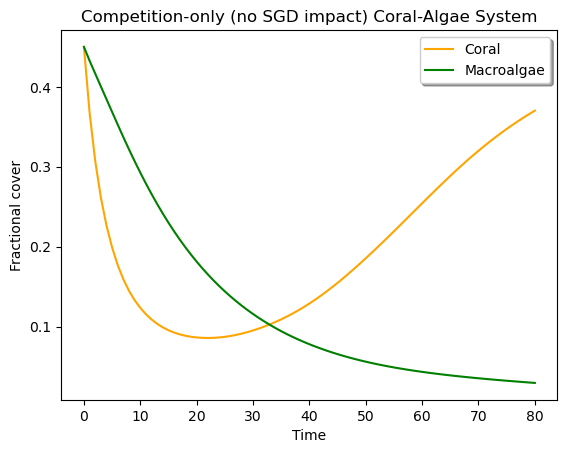

In [4]:
sol = solve_ivp(Mumby, [start,stop], [C0,M0], method='RK45', args=(r,a,g,mu,gamma), dense_output=True)
N = sol.sol(time_points)

coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Competition-only (no SGD impact) Coral-Algae System')
plt.show()

<a name = "plot_sgd_H1"></a>
### Plot Coral and Algae trajectories over time (SGD as growth impact factor)

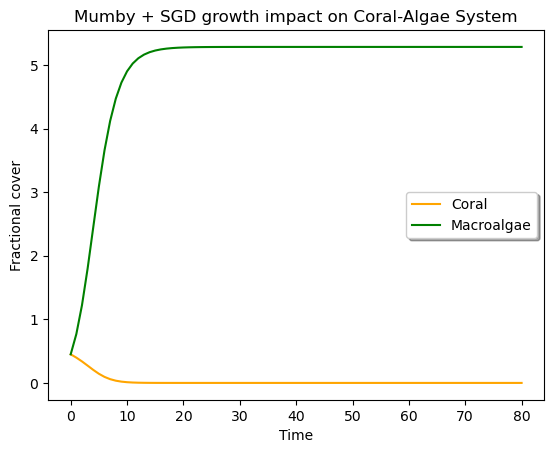

In [5]:
sol = solve_ivp(Mumby_SGD_H1, [start,stop], [C0,M0], method='RK45', args=(r,a,g,mu,gamma,nC,nM), dense_output=True)
N = sol.sol(time_points)

coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Mumby + SGD growth impact on Coral-Algae System')
plt.show()

<a name = "plot_sgd_H1"></a>
### Plot Coral and Algae trajectories over time (SGD as mortality impact factor)

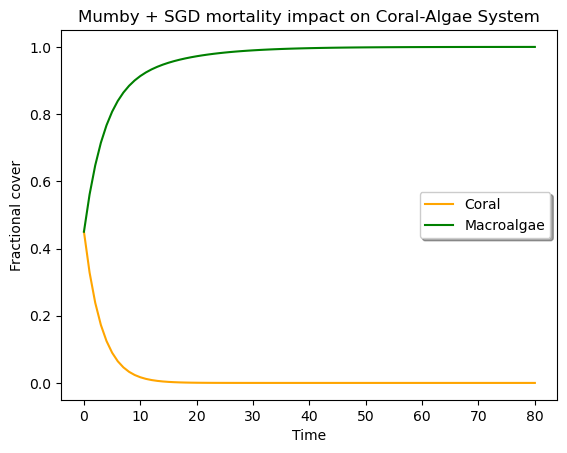

In [6]:
sol = solve_ivp(Mumby_SGD_H2, [start,stop], [C0,M0], method='RK45', args=(r,a,g,mu,gamma,nC,nM), dense_output=True)
N = sol.sol(time_points)

coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Mumby + SGD mortality impact on Coral-Algae System')
plt.show()

## Part 2: Analyze the system using a DIY numerical solver - 2 numerical integration methods

<a name = "calculate_derivative"></a>
### Calculate derivative $dN / dt$

#### Mumby model

<a name = "hypothesis_1_mumby"></a>

## Hypothesis 1: Mumby + SGD on growth impact

In [55]:
### Function to calculate the next value of C & M using the 2nd order Runge-Kutta method

def dNdt(C,M,P):
    
    dt = P['dt']
    
    #! Calculate the derivative
    dC = (r*(1-nC)*C*(1-C-M) - a*(1-nM)*C*M - mu*C) * dt #Coral equation
    dM = (gamma*(1-nM)*M*(1-C-M) + a*(1-nM)*C*M - g*M/(1-C)) * dt #Macroalgae equation

    return dC, dM

def RK2(C,M,P): #2nd-order Runge-Kutta
    
    C_init = C
    M_init = M
    
    dC1, dM1 = dNdt(C,M,P)
    
    C1 = C + 0.5*dC1
    M1 = M + 0.5*dM1
    
    dC2, dM2 = dNdt(C1,M1,P)
    
    dCave = (dC1 + dC2)/2
    dMave = (dM1 + dM2)/2
    
    C = C_init + dCave
    M = M_init + dMave
    
    return C, M


def run_model_RK2(INIT_C,INIT_M,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1] = RK2(C[step],M[step],P)
    
    return C, M

In [56]:
# Set other parameter values
r = 0.3 #coral growth
a = 0.2 #algal overgrowth onto coral
mu = 0.1 #coral background mortality
gamma = 0.7 #algal growth rate over turf
g = 0.3 #maximum grazing rate
nM = 0.05 #SGD impact factor on algae
nC = 0.1 #SGD impact factor on coral

# Initial population conditions
C0 = 0.45
M0 = 0.45

time_steps = 100 #no. of time steps
start = 0 
stop = 100
time_points = np.linspace(start, stop, time_steps+1)

dt = 0.1 #step size
NUMYEARS = 1000
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'r': r, 
                    'a': a,
                    'mu': mu,
                    'gamma': gamma,
                    'g': g,
                    'nC' : nC,
                    'nM' : nM
                    }

In [47]:
# # function for plotting

# def plot_h1(r,a,mu,gamma,g,nC,nM):

    
#     fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

#     for i in np.arange(0,100):
#         C0 = np.random.random()
#         M0 = np.random.random()
#         # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
#         if (C0 + M0 <= 1) : 
#             C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
#             if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
#                 color = 'orange'
#             else:
#                 color='green'
#             ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
#             item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
#             item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=60) # plot the final point in red
#             ax2.plot(C_array, c='orange', alpha=0.2) # plot the coral time series in plot B
#             ax2.plot(M_array, c='green', alpha=0.2) # plot the macroalgae time series in plot B

#     ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
#     ax1.set_xlabel("Coral cover", fontsize=16);
#     ax1.set_ylabel("Macroalgae cover", fontsize=16);
#     ax1.tick_params(axis='x', labelsize=14)
#     ax1.tick_params(axis='y', labelsize=14)
#     ax1.set_title('Coral-Algal Phase Plane \n r='+str(r)+', a='+str(a)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
#     ax1.set_xlim([-0.02,1])
#     ax1.set_ylim([-0.02,1])

#     ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
#     ax2.tick_params(axis='x', labelsize=14)
#     ax2.tick_params(axis='y', labelsize=14)
#     ax2.set_xlabel("Time", fontsize=16);
#     ax2.set_ylabel("Relative abundance", fontsize=16);
#     ax2.set_title('Coral reef community dynamics', fontsize=16)

    
# #plot_h1(r = 0.8, a = 0.3, mu = 0.05, gamma = 0.2, g = 0.05, nM = 0, nC = 0)

In [57]:
# ### RANDOMIZE SGD IMPACT FACTOR n

# # set initial conditions for C0 and M0
# C0 = 0.45
# M0 = 0.45
# r = 0.2 # coral growth over algae
# a = 0.3 # algal growth over coral
# mu = 0.05 # coral mortality
# gamma = 0.2 # algal growth over turf
# g = 0.1 # maximum grazing

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

# for i in np.arange(0,100):
#     nC = np.random.random()
#     nM = np.random.random()
            
#     C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
        
#     if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
#         color = 'orange'
#     else:
#         color='green'
        
#     ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
#     item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
#     item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
#     ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
#     ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B

# ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
# ax1.set_xlabel("Coral cover", fontsize=16);
# ax1.set_ylabel("Macroalgae cover", fontsize=16);
# ax1.tick_params(axis='x', labelsize=14)
# ax1.tick_params(axis='y', labelsize=14)
# ax1.set_title('Coral-Algal Phase Plane \n r='+str(r)+', a='+str(a)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# ax1.set_xlim([-0.02,1])
# ax1.set_ylim([-0.02,1])

# ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
# ax2.tick_params(axis='x', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xlabel("Time", fontsize=16);
# ax2.set_ylabel("Relative abundance", fontsize=16);
# ax2.set_title('Coral reef community dynamics', fontsize=16);
# # plt.savefig("Output/H1_Mumby_Rand_SGD_n.png", dpi=300);

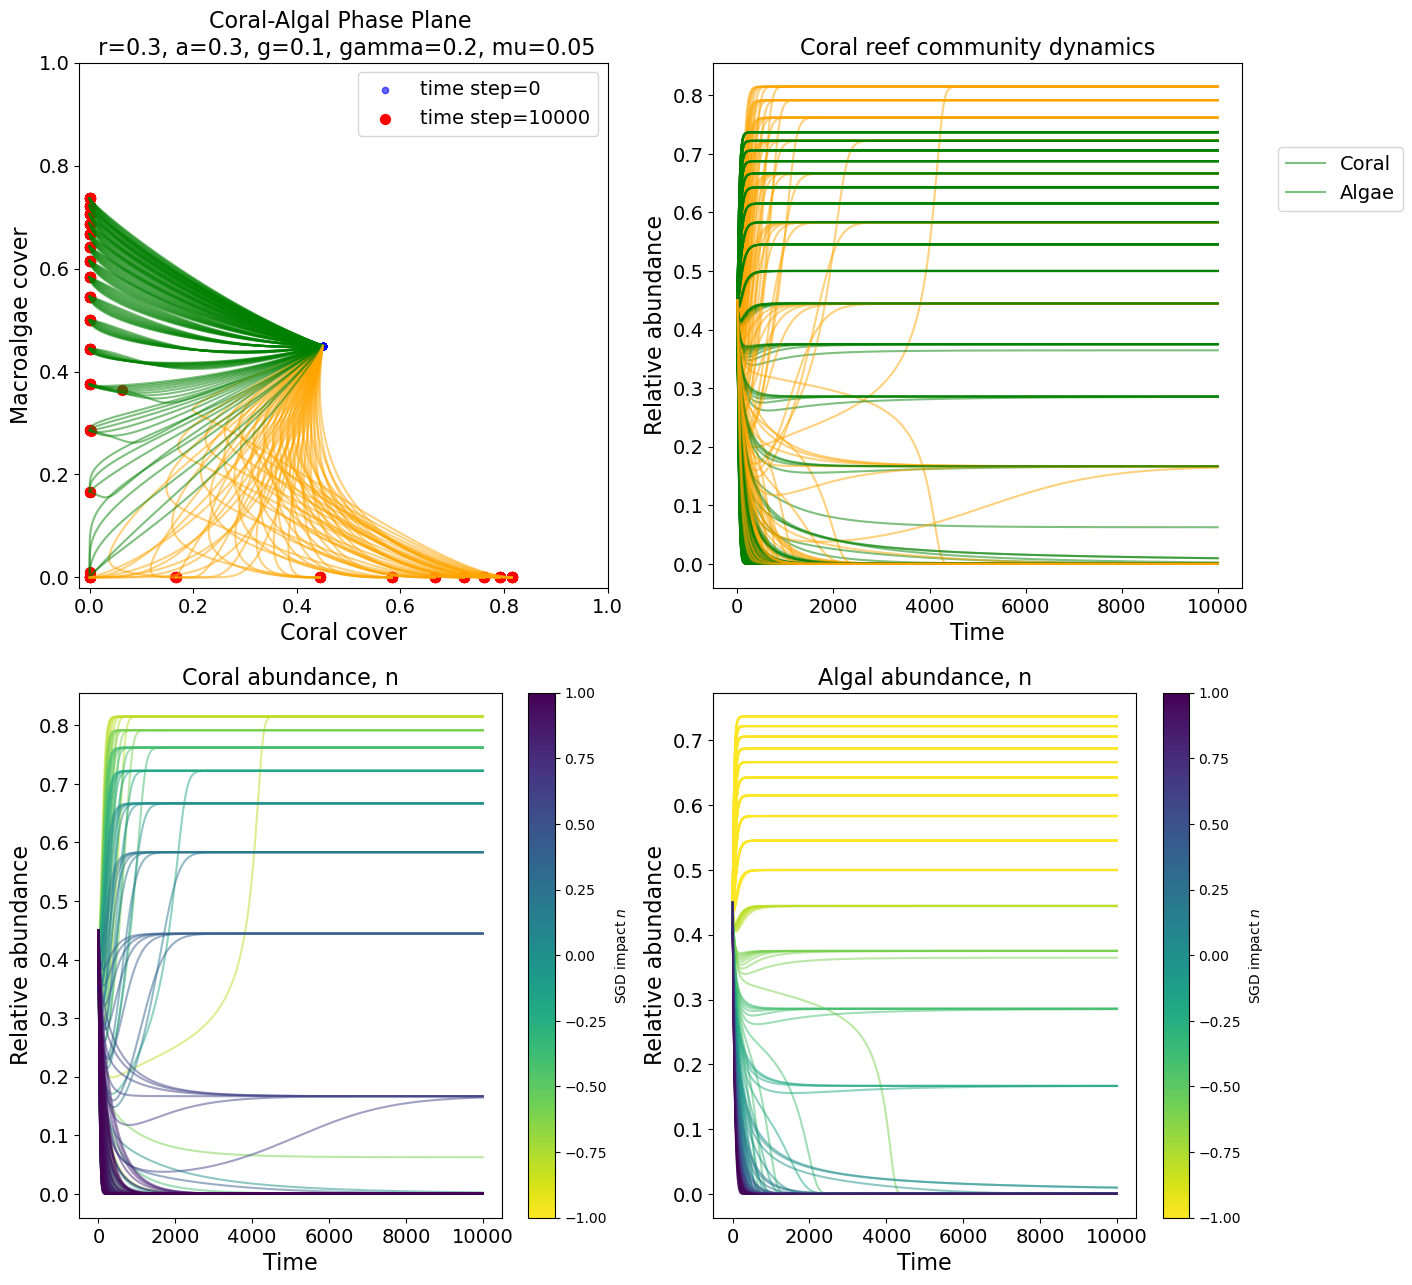

In [50]:
# maintain initial population size
C0 = 0.45
M0 = 0.45
r = 0.3 # coral growth over algae
a = 0.3 # algal growth over coral
mu = 0.05
gamma = 0.2 # algal growth over turf
g = 0.1

# initial SGD impact factors
nC = 0
nM = -1

step = 0.1

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs


for i in range(0, 10):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    
    for j in range(0,20):
        nM = nM + step
    
        # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
        if (C0 + M0 <= 1) : 
            C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
            if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                color = 'orange'
            else:
                color='green'
            ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
            item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
            item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
            ax2.plot(C_array, c=color, alpha=0.5) # plot the coral time series in plot B
            ax2.plot(M_array, c=color, alpha=0.5) # plot the macroalgae time series in plot B
            ax3.plot(C_array, c=cmap(nC), alpha=0.5)
            ax4.plot(M_array, c=cmap(nM), alpha=0.5)


normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane \n r='+str(r)+', a='+str(a)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);
plt.savefig("Output/H1_Mumby_iter_SGD_n.png", dpi=300);

### Iterate over nC, nM, and a

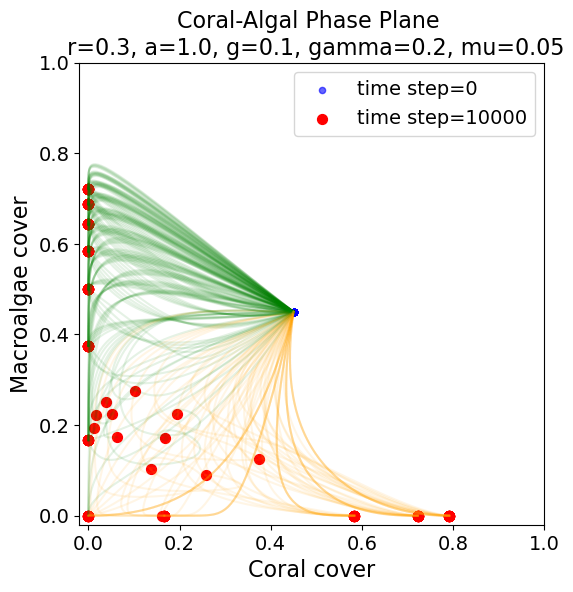

In [51]:
# iterate nC 
    # iterate nM
        # iterate a

# initial SGD impact factors
nC = 0
nM = -1
a = 0

step = 0.2

fig, (ax1) = plt.subplots(ncols=1, figsize=(6,6))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    
    for j in range(0,10):
        nM = nM + step
        a = 0
        
        for k in range(0,5):
            a = a + step
    
            # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
            if (C0 + M0 <= 1) : 
                C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                    color = 'orange'
                else:
                    color='green'
                ax1.plot(C_array, M_array, color=color, alpha=0.1) # plot the trajectory in the phase plane (plot A)
                item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
                item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red

            
ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane \n r='+str(r)+', a='+str(a)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1]);
plt.savefig("Output/H1_Mumby_iter_SGD_n_a.png", dpi=300);

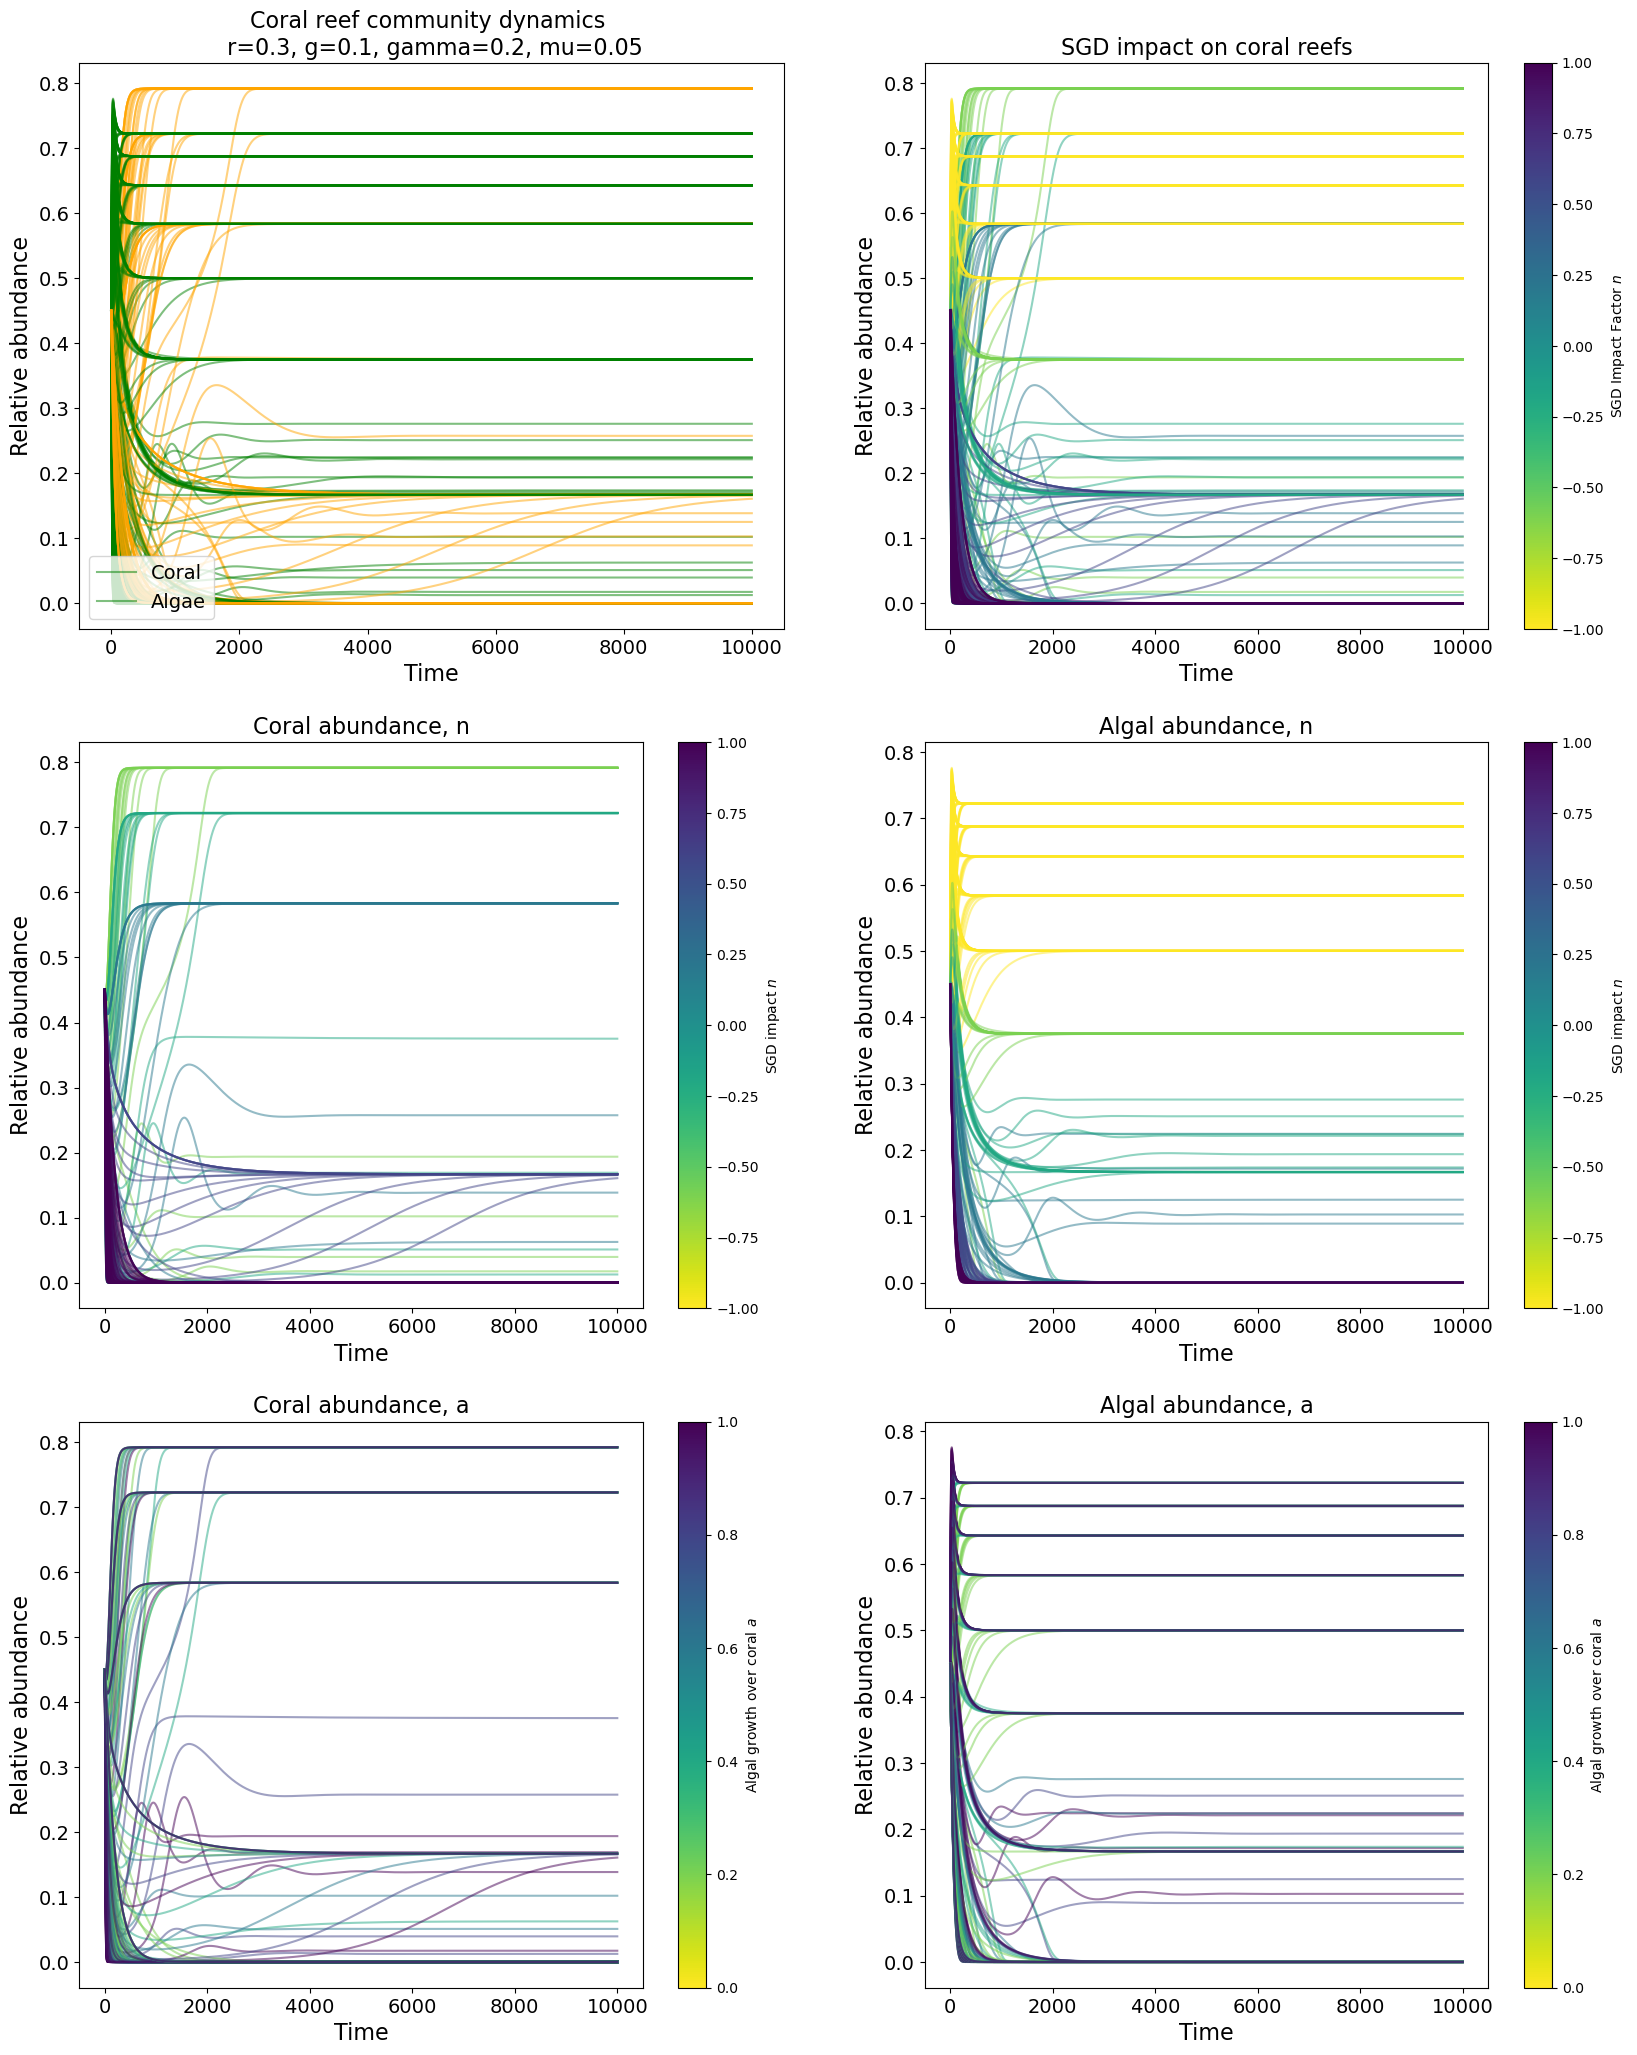

In [52]:

# initial SGD impact factors
nC = 0
nM = -1
a = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,25))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    
    for j in range(0,10):
        nM = nM + step
        a = 0
        
        for k in range(0,5):
            a = a + step
            
            if (C0 + M0 <= 1) : 
                C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
            if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                color = 'orange'
            else:
                color='green'
            ax1.plot(C_array, color = color, alpha = 0.5)
            ax1.plot(M_array, color = color, alpha = 0.5)
            ax2.plot(C_array, c=cmap(nC), alpha=0.5) # plot the coral time series in plot B
            ax2.plot(M_array, c=cmap(nM), alpha=0.5) # plot the macroalgae time series in plot B
            ax3.plot(C_array, c=cmap(nC), alpha=0.5)
            ax4.plot(M_array, c=cmap(nM), alpha=0.5)
            ax5.plot(C_array, c=cmap(a), alpha=0.5)
            ax6.plot(M_array, c=cmap(a), alpha=0.5)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n r='+str(r)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);
plt.savefig("Output/H1_Mumby_iter_n_a.png", dpi=300);

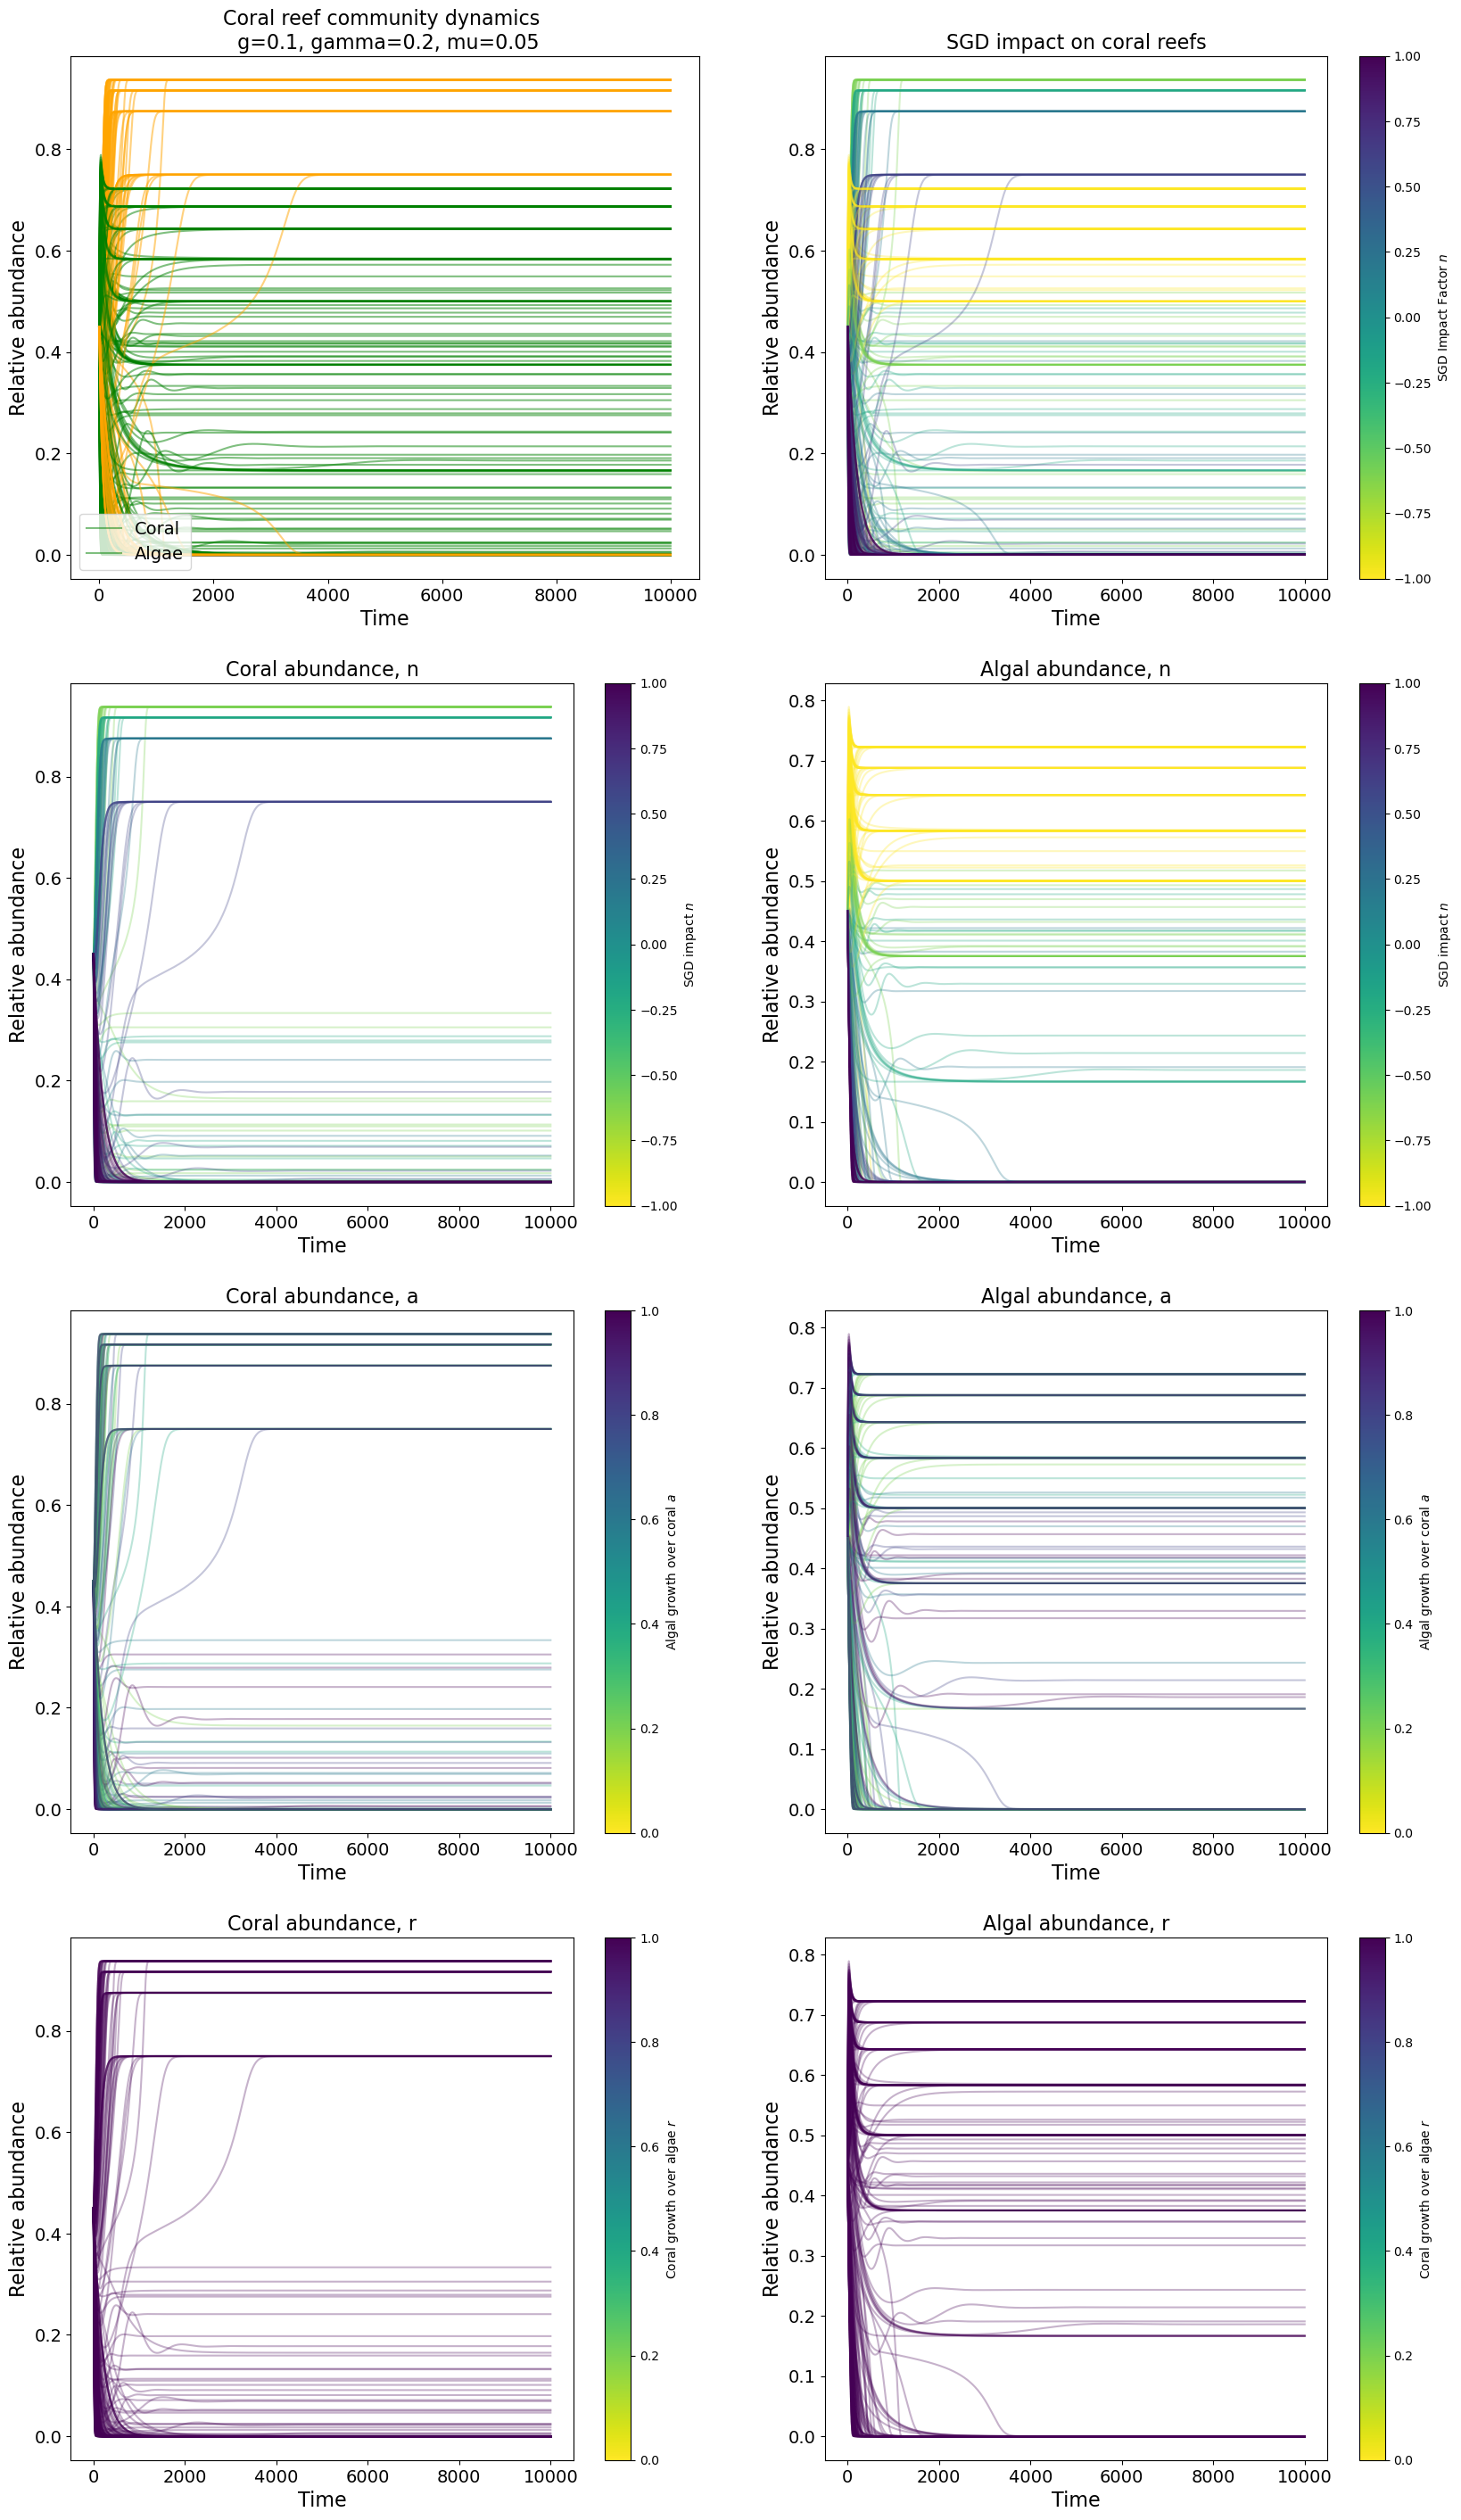

In [53]:

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,35))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            
            for m in range(0,5):
                r = r + step
            
            if (C0 + M0 <= 1) : 
                C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
            if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                color = 'orange'
            else:
                color='green'
            ax1.plot(C_array, color = color, alpha = 0.5)
            ax1.plot(M_array, color = color, alpha = 0.5)
            ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
            ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
            ax3.plot(C_array, c=cmap(nC), alpha=0.3)
            ax4.plot(M_array, c=cmap(nM), alpha=0.3)
            ax5.plot(C_array, c=cmap(a), alpha=0.3)
            ax6.plot(M_array, c=cmap(a), alpha=0.3)
            ax7.plot(C_array, c=cmap(r), alpha=0.3)
            ax8.plot(M_array, c=cmap(r), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);
plt.savefig("Output/H1_Mumby_iter_n_a_r.png", dpi=300);

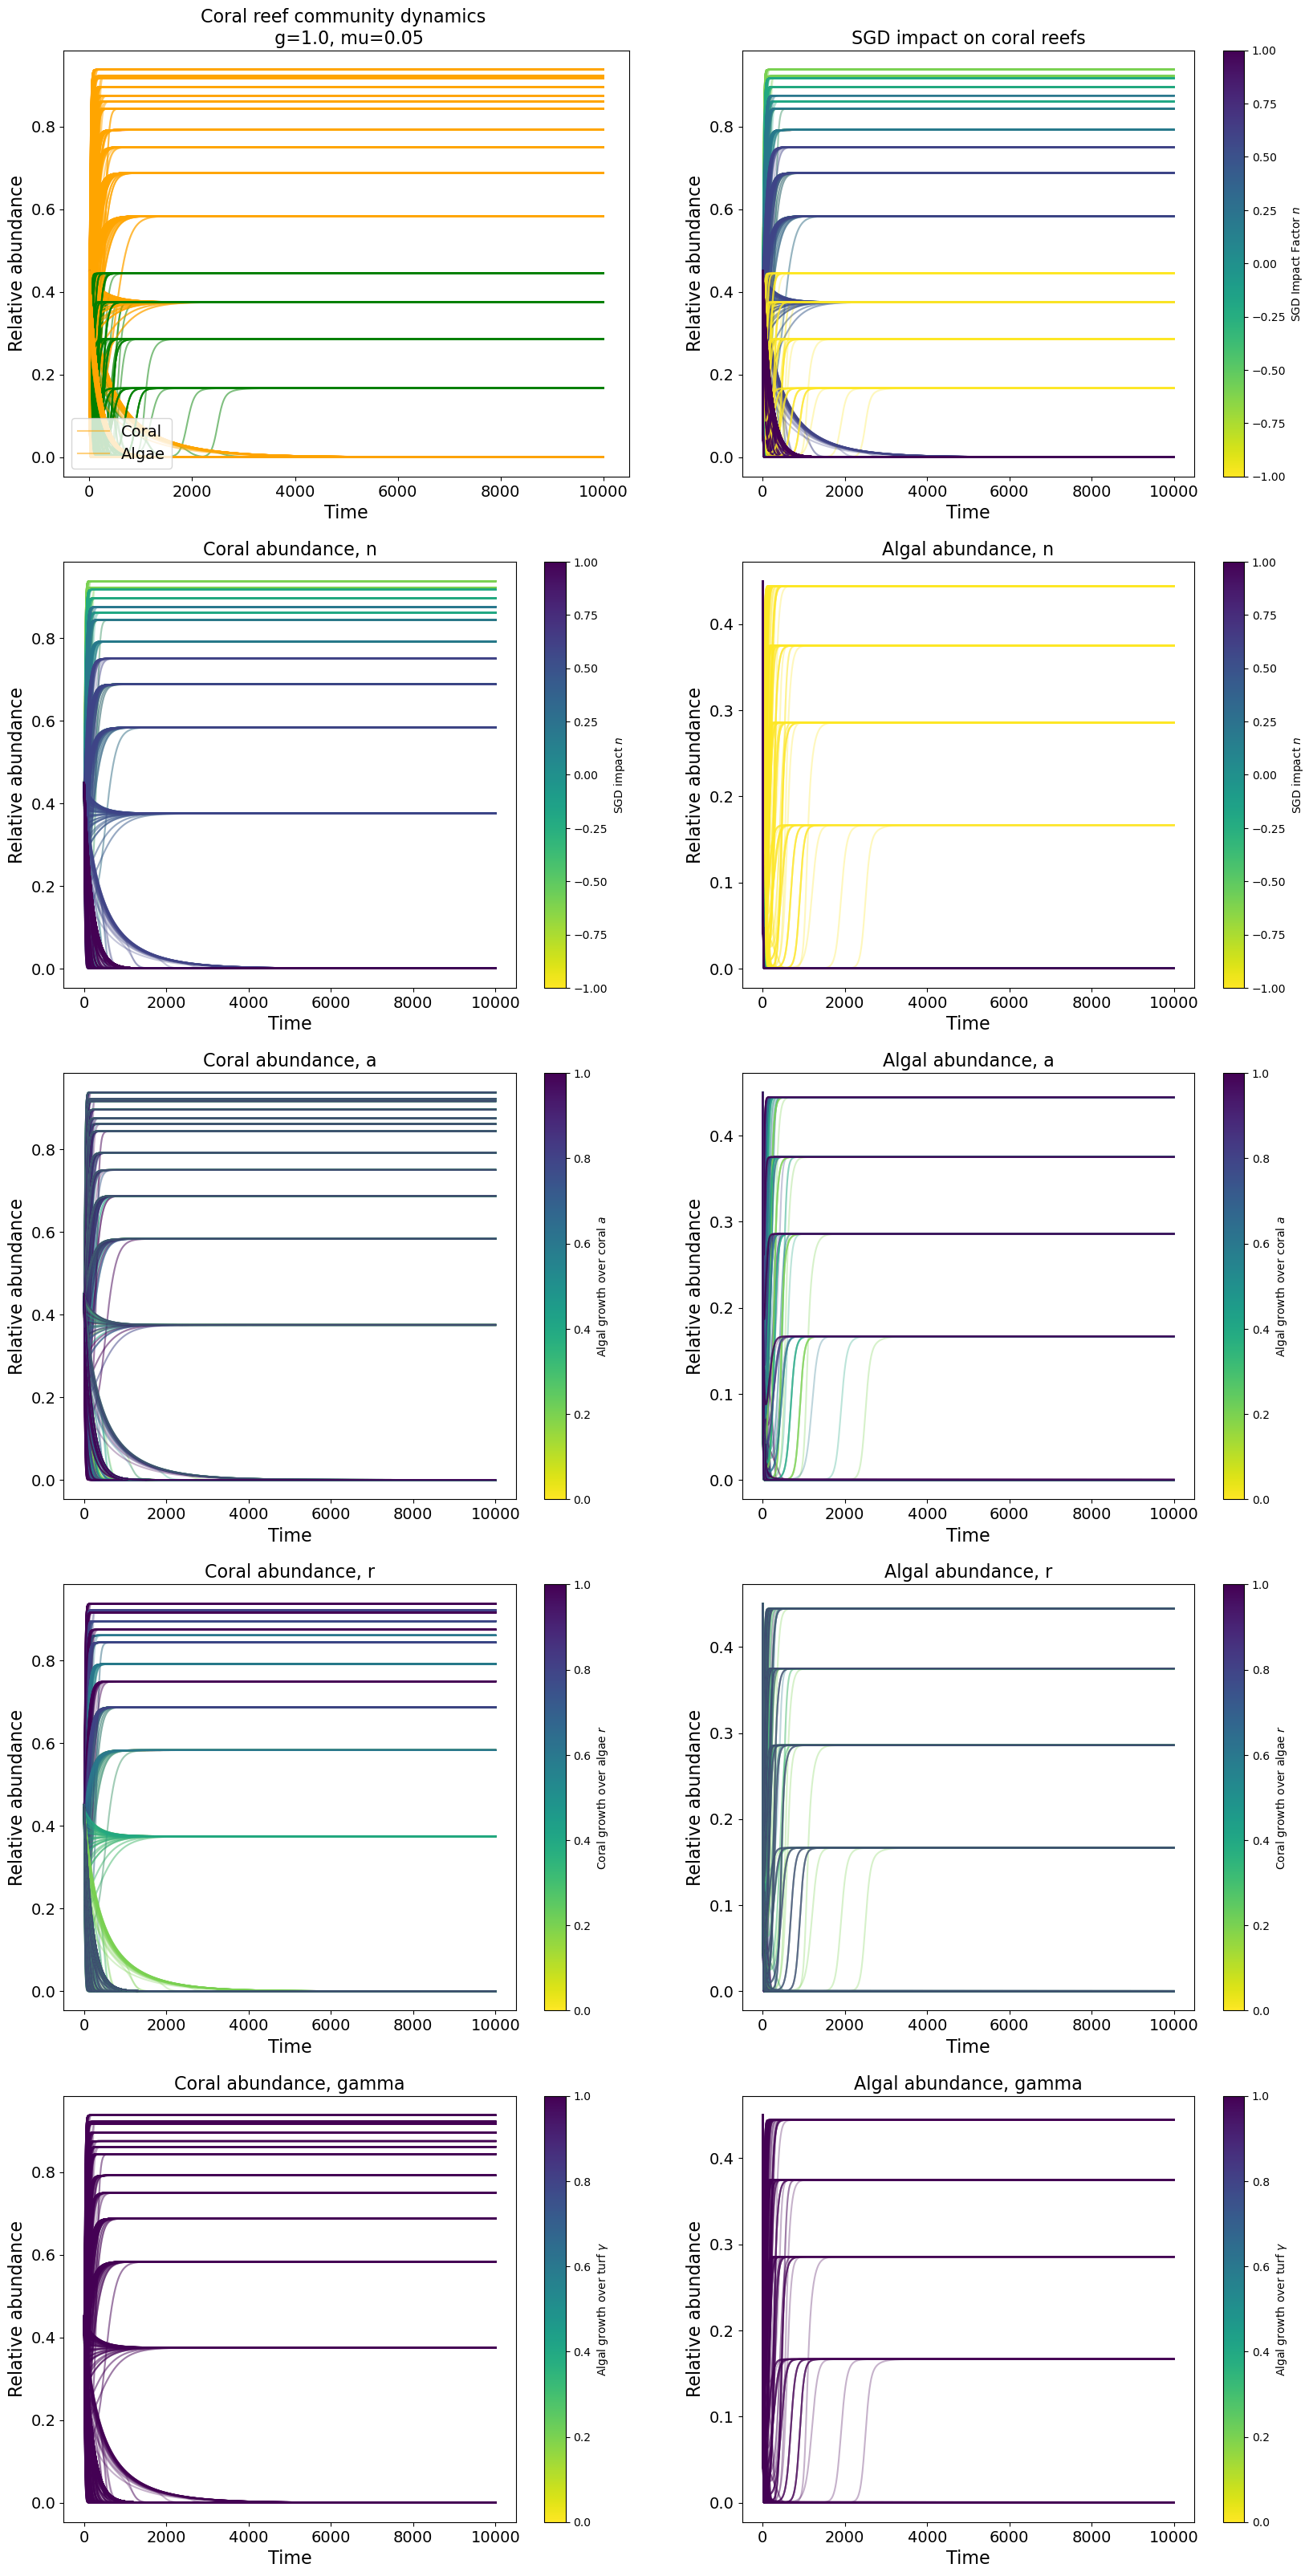

In [43]:

# time interval
# dt = 0.1 #step size
# NUMYEARS = 1000
# NUMSTEPS = int(NUMYEARS/dt)

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0
gamma = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20,40))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    gamma = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        gamma = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            gamma = 0
            
            for m in range(0,5):
                r = r + step
                gamma = 0
                
                for p in range(0,5):
                    gamma = gamma + step
            
                if (C0 + M0 <= 1) : 
                    C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                    color = 'orange'
                else:
                    color='green'
                ax1.plot(C_array, color = color, alpha = 0.5)
                ax1.plot(M_array, color = color, alpha = 0.5)
                ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
                ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
                ax3.plot(C_array, c=cmap(nC), alpha=0.3)
                ax4.plot(M_array, c=cmap(nM), alpha=0.3)
                ax5.plot(C_array, c=cmap(a), alpha=0.3)
                ax6.plot(M_array, c=cmap(a), alpha=0.3)
                ax7.plot(C_array, c=cmap(r), alpha=0.3)
                ax8.plot(M_array, c=cmap(r), alpha=0.3)
                ax9.plot(C_array, c=cmap(gamma), alpha=0.3)
                ax10.plot(M_array, c=cmap(gamma), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n g='+str(g)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax9, label = 'Algal growth over turf $\gamma$')
ax9.tick_params(axis='x', labelsize=14)
ax9.tick_params(axis='y', labelsize=14)
ax9.set_xlabel("Time", fontsize=16);
ax9.set_ylabel("Relative abundance", fontsize=16);
ax9.set_title('Coral abundance, gamma', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax10, label = 'Algal growth over turf $\gamma$')
ax10.tick_params(axis='x', labelsize=14)
ax10.tick_params(axis='y', labelsize=14)
ax10.set_xlabel("Time", fontsize=16);
ax10.set_ylabel("Relative abundance", fontsize=16)
ax10.set_title('Algal abundance, gamma', fontsize=16);
plt.savefig("Output/H1_Mumby_iter_n_a_r_gamma.png", dpi=300);

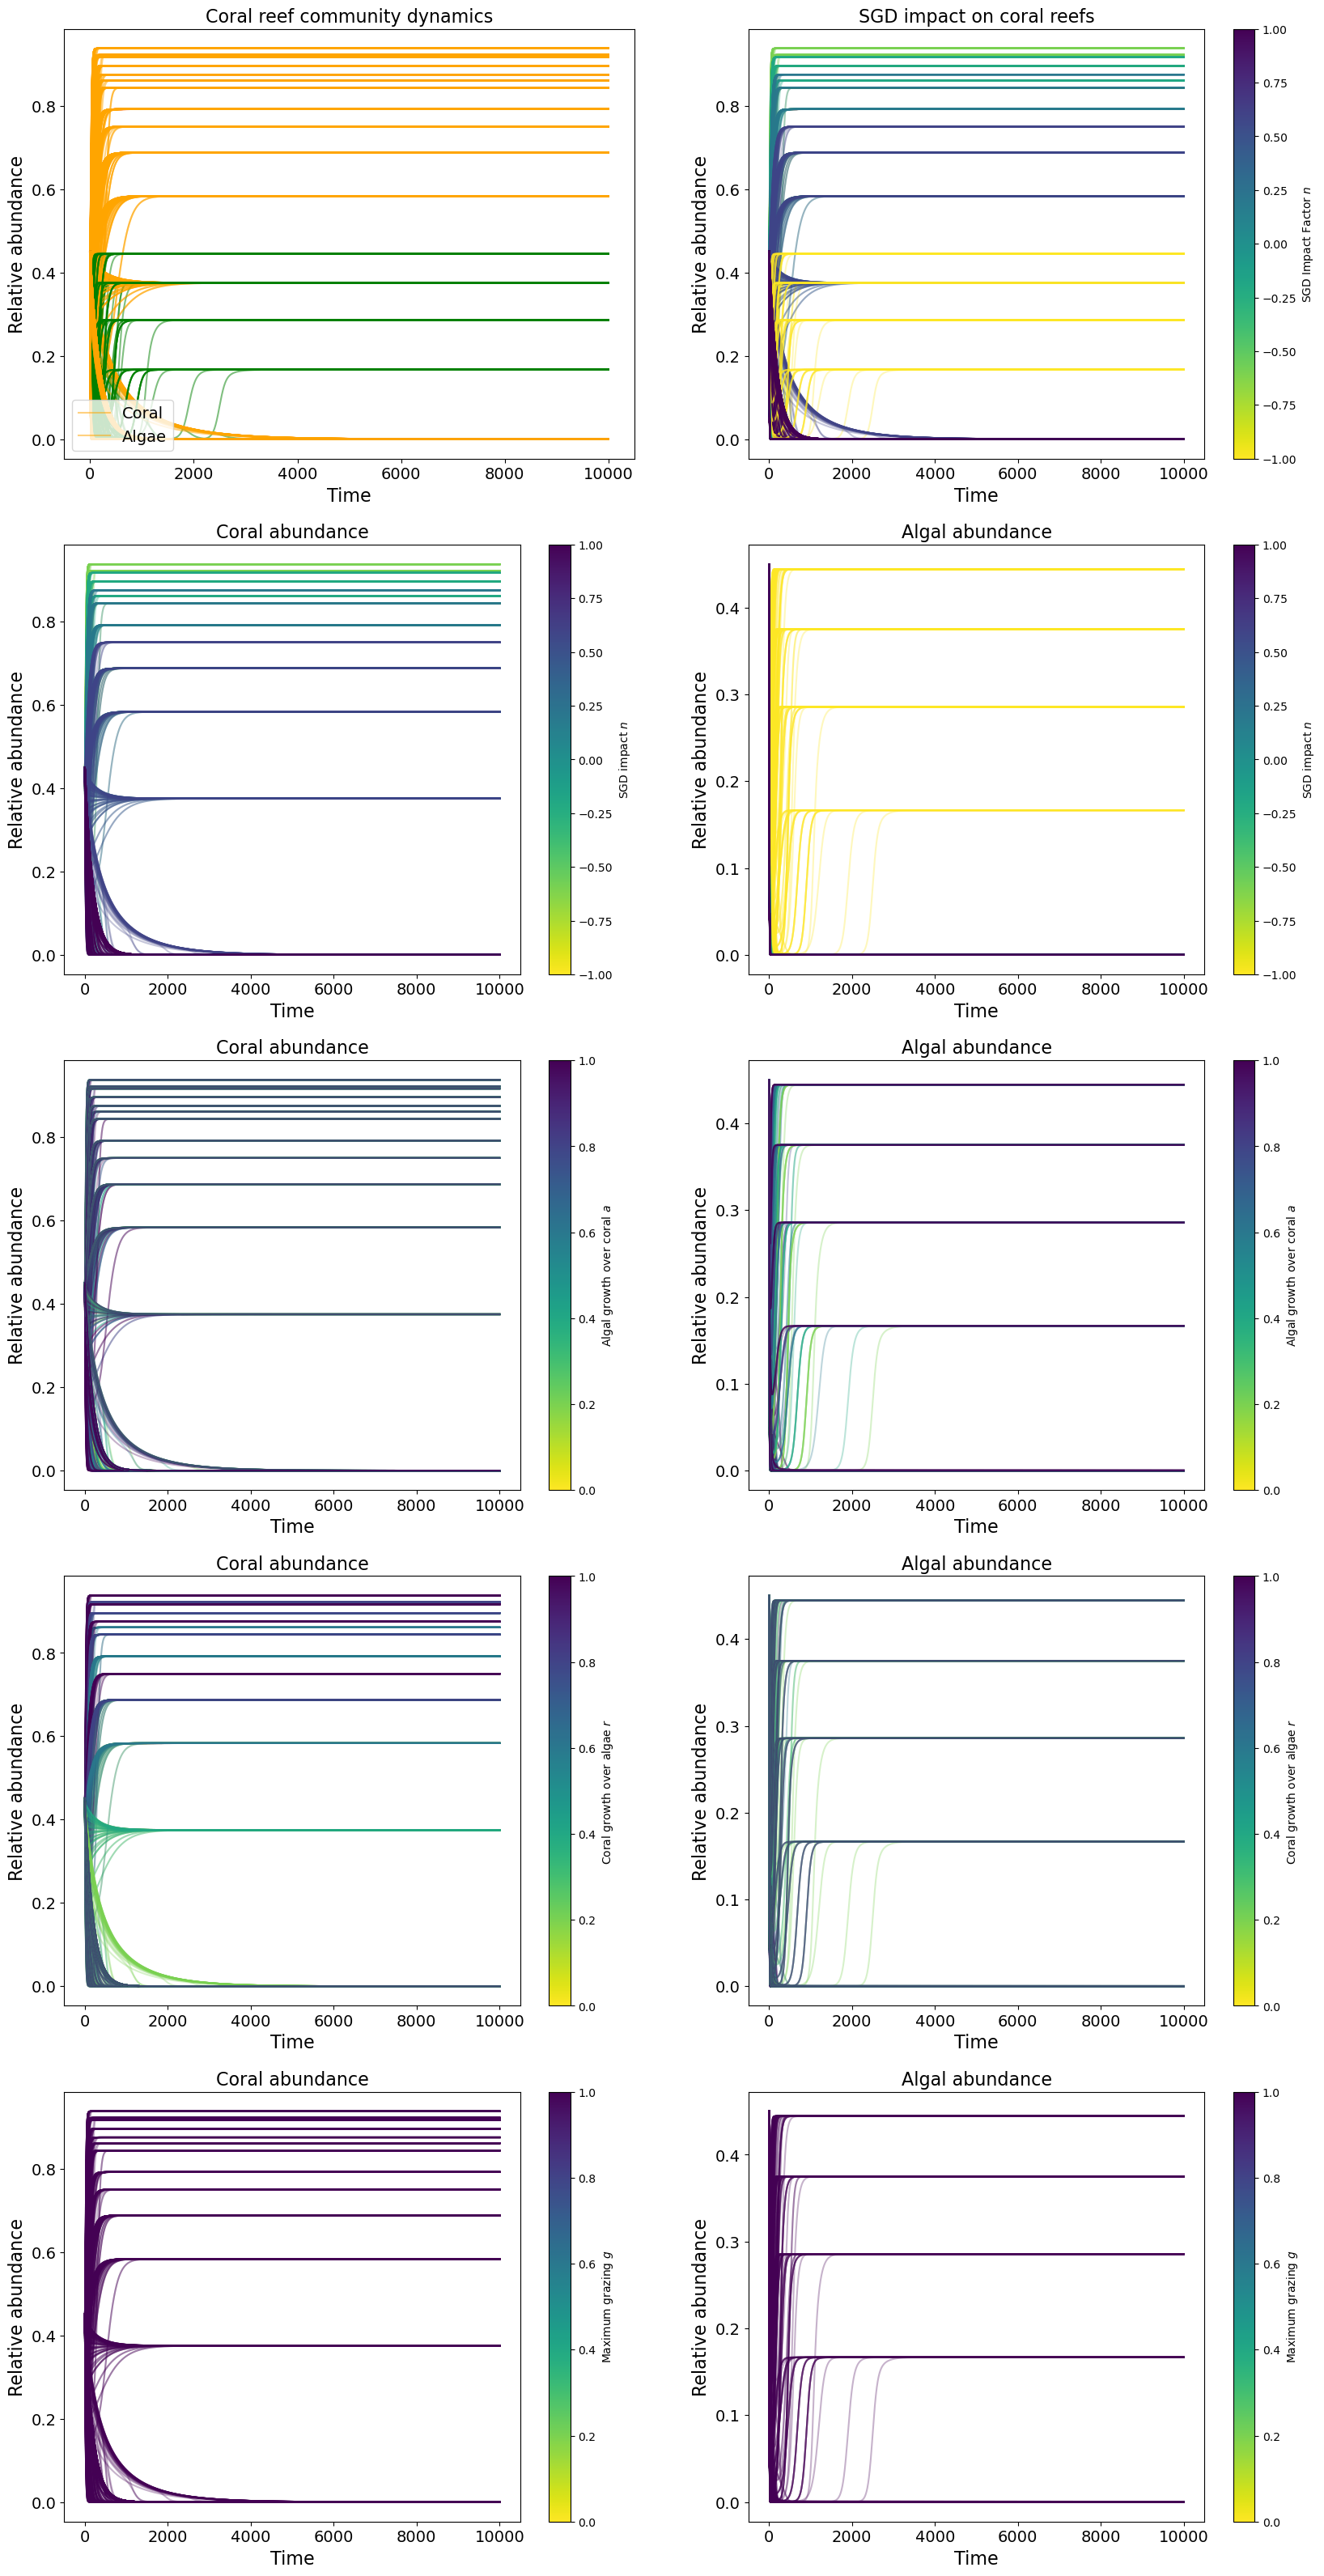

In [42]:

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0
g = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20,40))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    g = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        g = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            g = 0
            
            for m in range(0,5):
                r = r + step
                g = 0
                
                for p in range(0,5):
                    g = g + step
            
                if (C0 + M0 <= 1) : 
                    C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                    color = 'orange'
                else:
                    color='green'
                ax1.plot(C_array, color = color, alpha = 0.5)
                ax1.plot(M_array, color = color, alpha = 0.5)
                ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
                ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
                ax3.plot(C_array, c=cmap(nC), alpha=0.3)
                ax4.plot(M_array, c=cmap(nM), alpha=0.3)
                ax5.plot(C_array, c=cmap(a), alpha=0.3)
                ax6.plot(M_array, c=cmap(a), alpha=0.3)
                ax7.plot(C_array, c=cmap(r), alpha=0.3)
                ax8.plot(M_array, c=cmap(r), alpha=0.3)
                ax9.plot(C_array, c=cmap(g), alpha=0.3)
                ax10.plot(M_array, c=cmap(g), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax9, label = 'Maximum grazing $g$')
ax9.tick_params(axis='x', labelsize=14)
ax9.tick_params(axis='y', labelsize=14)
ax9.set_xlabel("Time", fontsize=16);
ax9.set_ylabel("Relative abundance", fontsize=16);
ax9.set_title('Coral abundance, g', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax10, label = 'Maximum grazing $g$')
ax10.tick_params(axis='x', labelsize=14)
ax10.tick_params(axis='y', labelsize=14)
ax10.set_xlabel("Time", fontsize=16);
ax10.set_ylabel("Relative abundance", fontsize=16)
ax10.set_title('Algal abundance, g', fontsize=16);
plt.savefig("Output/H1_Mumby_iter_n_a_r_g.png", dpi=300);

[Back to Hypothesis 1](#hypothesis_1_mumby)

<a name = "hypothesis_2_mumby"></a>

## Hypothesis 2: Mumby + SGD on mortality impact

In [66]:
def dNdt(C,M,P):
    
    dt = P['dt']
    
    #! Calculate the derivative
    dC = (r*C*(1-C-M) - a*C*M - mu*C - nC*C) * dt #Coral equation
    dM = (gamma*M*(1-C-M) + a*C*M - g*M/(1-C) - nM*M) * dt #Macroalgae equation

    return dC, dM


### Function to calculate the next value of C & M using the 2nd order Runge-Kutta method

def RK2(C,M,P): #2nd-order Runge-Kutta
    
    C_init = C
    M_init = M
    
    dC1, dM1 = dNdt(C,M,P)
    
    C1 = C + 0.5*dC1
    M1 = M + 0.5*dM1
    
    dC2, dM2 = dNdt(C1,M1,P)
    
    dCave = (dC1 + dC2)/2
    dMave = (dM1 + dM2)/2
    
    C = C_init + dCave
    M = M_init + dMave
    
    return C, M




def run_model_RK2(INIT_C,INIT_M,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1] = RK2(C[step],M[step],P)
    
    return C, M

In [70]:
# Set other parameter values
r = 0.3 # coral growth over algae
a = 0.3 # algal growth over coral
mu = 0.05
gamma = 0.2 # algal growth over turf
g = 0.1
nM = 0.05 #SGD impact factor on algae
nC = 0.1 #SGD impact factor on coral

# Initial population conditions
C0 = 0.45
M0 = 0.45

time_steps = 100 #no. of time steps
start = 0 
stop = 100
time_points = np.linspace(start, stop, time_steps+1)

dt = 0.1 #step size
NUMYEARS = 1000
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'r': r, 
                    'a': a,
                    'mu': mu,
                    'gamma': gamma,
                    'g': g,
                    'nC' : nC,
                    'nM' : nM
                    }

In [63]:
# ### RANDOMIZE INITIAL POPULATION SIZE C AND M

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

# for i in np.arange(0,100):
#     C0 = np.random.random()
#     M0 = np.random.random()
#     # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
#     if (C0 + M0 <= 1) : 
#         C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
#         if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
#             color = 'orange'
#         else:
#             color='green'
#         ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
#         item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
#         item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
#         ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
#         ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B

# ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
# ax1.set_xlabel("Coral cover", fontsize=16);
# ax1.set_ylabel("Macroalgae cover", fontsize=16);
# ax1.tick_params(axis='x', labelsize=14)
# ax1.tick_params(axis='y', labelsize=14)
# ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
# ax1.set_xlim([-0.02,1])
# ax1.set_ylim([-0.02,1])

# ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
# ax2.tick_params(axis='x', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xlabel("Time", fontsize=16);
# ax2.set_ylabel("Relative abundance", fontsize=16);
# ax2.set_title('Coral reef community dynamics', fontsize=16);
# # plt.savefig("Output/H2_Mumby_Rand_InitPop.png", dpi=300);

In [64]:
# ### RANDOMIZE SGD IMPACT FACTOR n

# # initial population size
# C0 = 0.45
# M0 = 0.45

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

# for i in np.arange(0,100):
#     nC = np.random.random()
#     nM = np.random.random()
#     # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
#     if (C0 + M0 <= 1) : 
#         C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
#         if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
#             color = 'orange'
#         else:
#             color='green'
#         ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
#         item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
#         item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
#         ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
#         ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B

# ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
# ax1.set_xlabel("Coral cover", fontsize=16);
# ax1.set_ylabel("Macroalgae cover", fontsize=16);
# ax1.tick_params(axis='x', labelsize=14)
# ax1.tick_params(axis='y', labelsize=14)
# ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
# ax1.set_xlim([-0.02,1])
# ax1.set_ylim([-0.02,1])

# ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
# ax2.tick_params(axis='x', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xlabel("Time", fontsize=16);
# ax2.set_ylabel("Relative abundance", fontsize=16);
# ax2.set_title('Coral reef community dynamics', fontsize=16);
# # plt.savefig("Output/H2_Mumby_Rand_SGD_n.png", dpi=300);

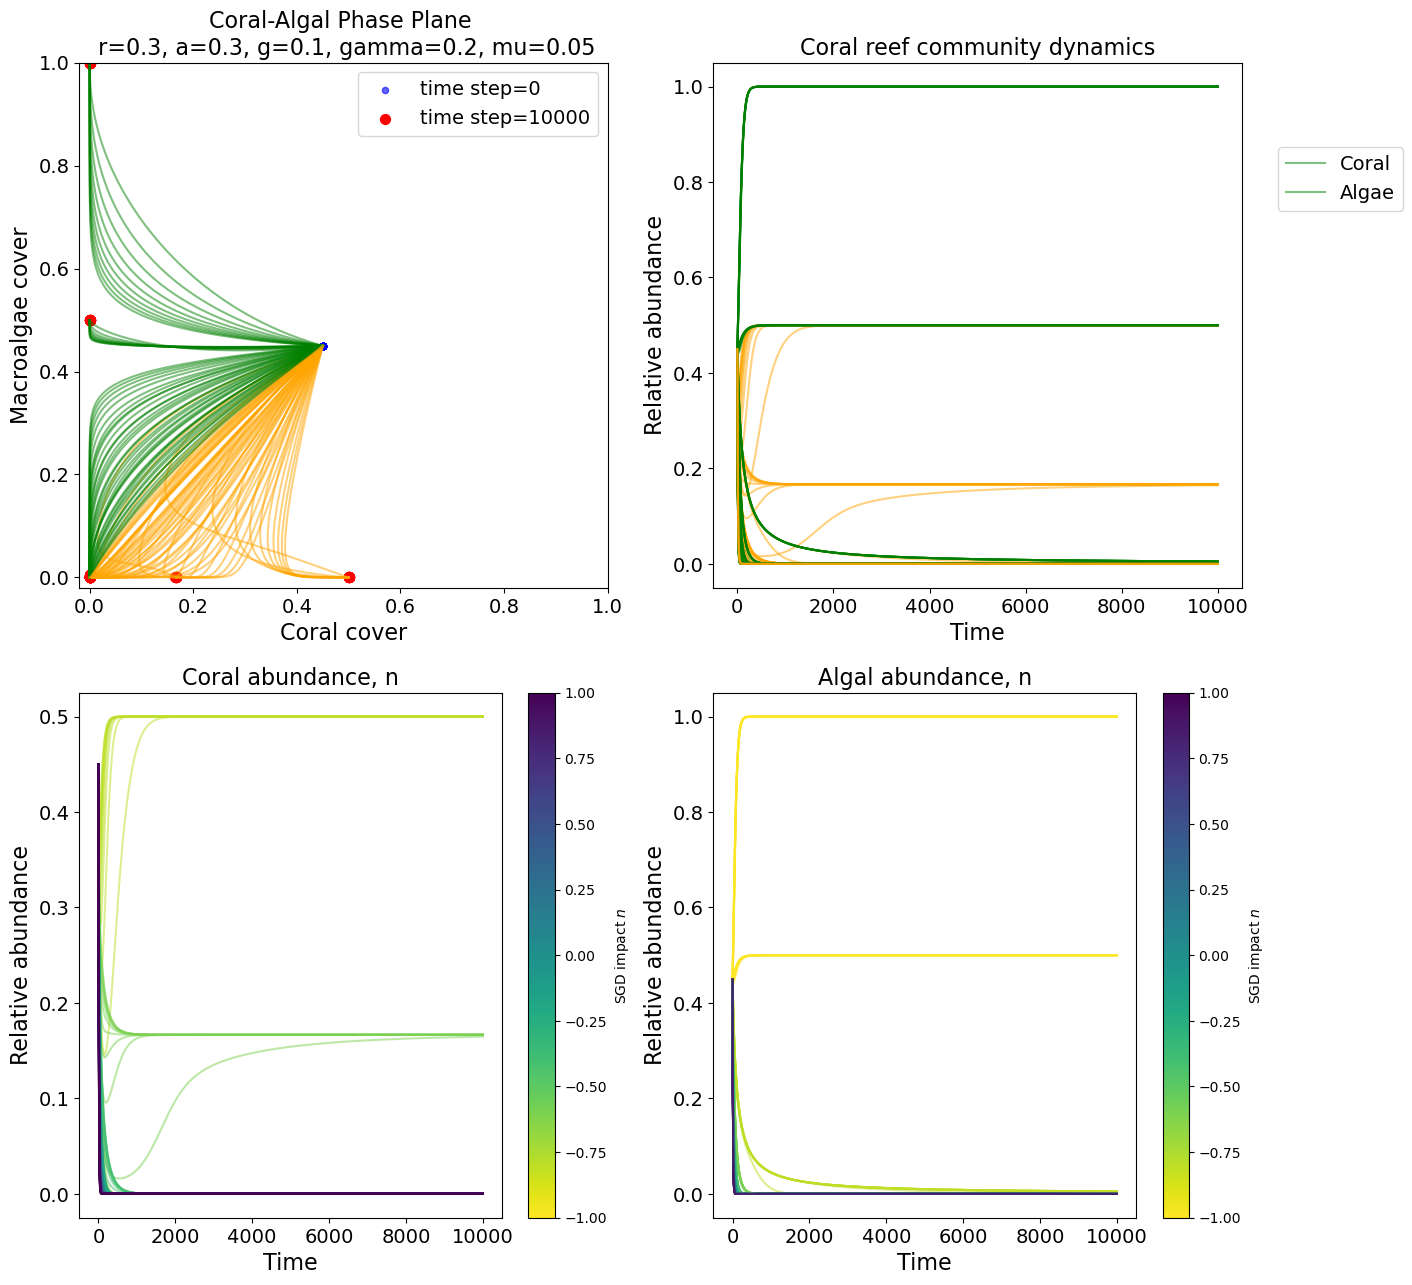

In [71]:
# maintain initial population size
C0 = 0.45
M0 = 0.45
r = 0.3 # coral growth over algae
a = 0.3 # algal growth over coral
mu = 0.05
gamma = 0.2 # algal growth over turf
g = 0.1

# initial SGD impact factors
nC = 0
nM = -1

step = 0.1

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 10):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    
    for j in range(0,20):
        nM = nM + step
    
        # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
        if (C0 + M0 <= 1) : 
            C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
            if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                color = 'orange'
            else:
                color='green'
            if (C_array[-1] + M_array[-1] <= 1) : 
                ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
                item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
                item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
                ax2.plot(C_array, c=color, alpha=0.5) # plot the coral time series in plot B
                ax2.plot(M_array, c=color, alpha=0.5) # plot the macroalgae time series in plot B
                ax3.plot(C_array, c=cmap(nC), alpha=0.5)
                ax4.plot(M_array, c=cmap(nM), alpha=0.5)


normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane \n r='+str(r)+', a='+str(a)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);
plt.savefig("Output/H2_Mumby_iter_SGD_n.png", dpi=300);

## Iterate nC, nM, and a

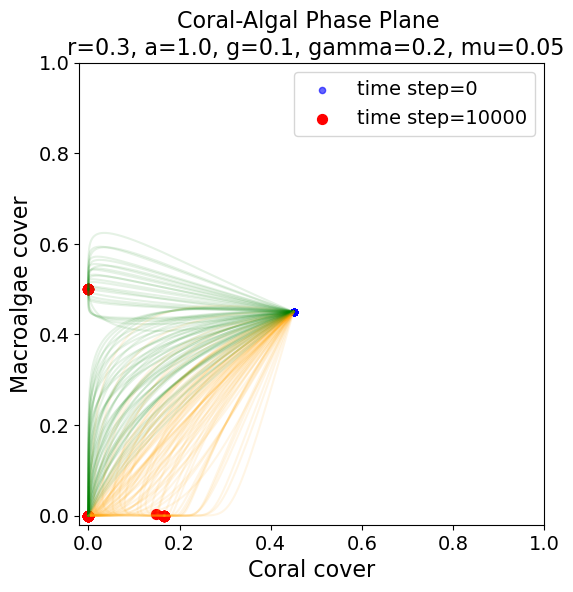

In [72]:
# iterate nC 
    # iterate nM
        # iterate a

# initial SGD impact factors
nC = 0
nM = -1
a = 0

step = 0.2

fig, (ax1) = plt.subplots(ncols=1, figsize=(6,6))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    
    for j in range(0,10):
        nM = nM + step
        a = 0
        
        for k in range(0,5):
            a = a + step
    
            # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
            if (C0 + M0 <= 1) : 
                C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                    color = 'orange'
                else:
                    color='green'
                if (C_array[-1] + M_array[-1] <= 1) : 
                    ax1.plot(C_array, M_array, color=color, alpha=0.1) # plot the trajectory in the phase plane (plot A)
                    item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
                    item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red

            
ax1.legend([item1, item2], ['time step=0', 'time step='+str(len(C_array))], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane \n r='+str(r)+', a='+str(a)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1]);
plt.savefig("Output/H2_Mumby_iter_SGD_n_a.png", dpi=300);

## Iterate nC, nM, and a

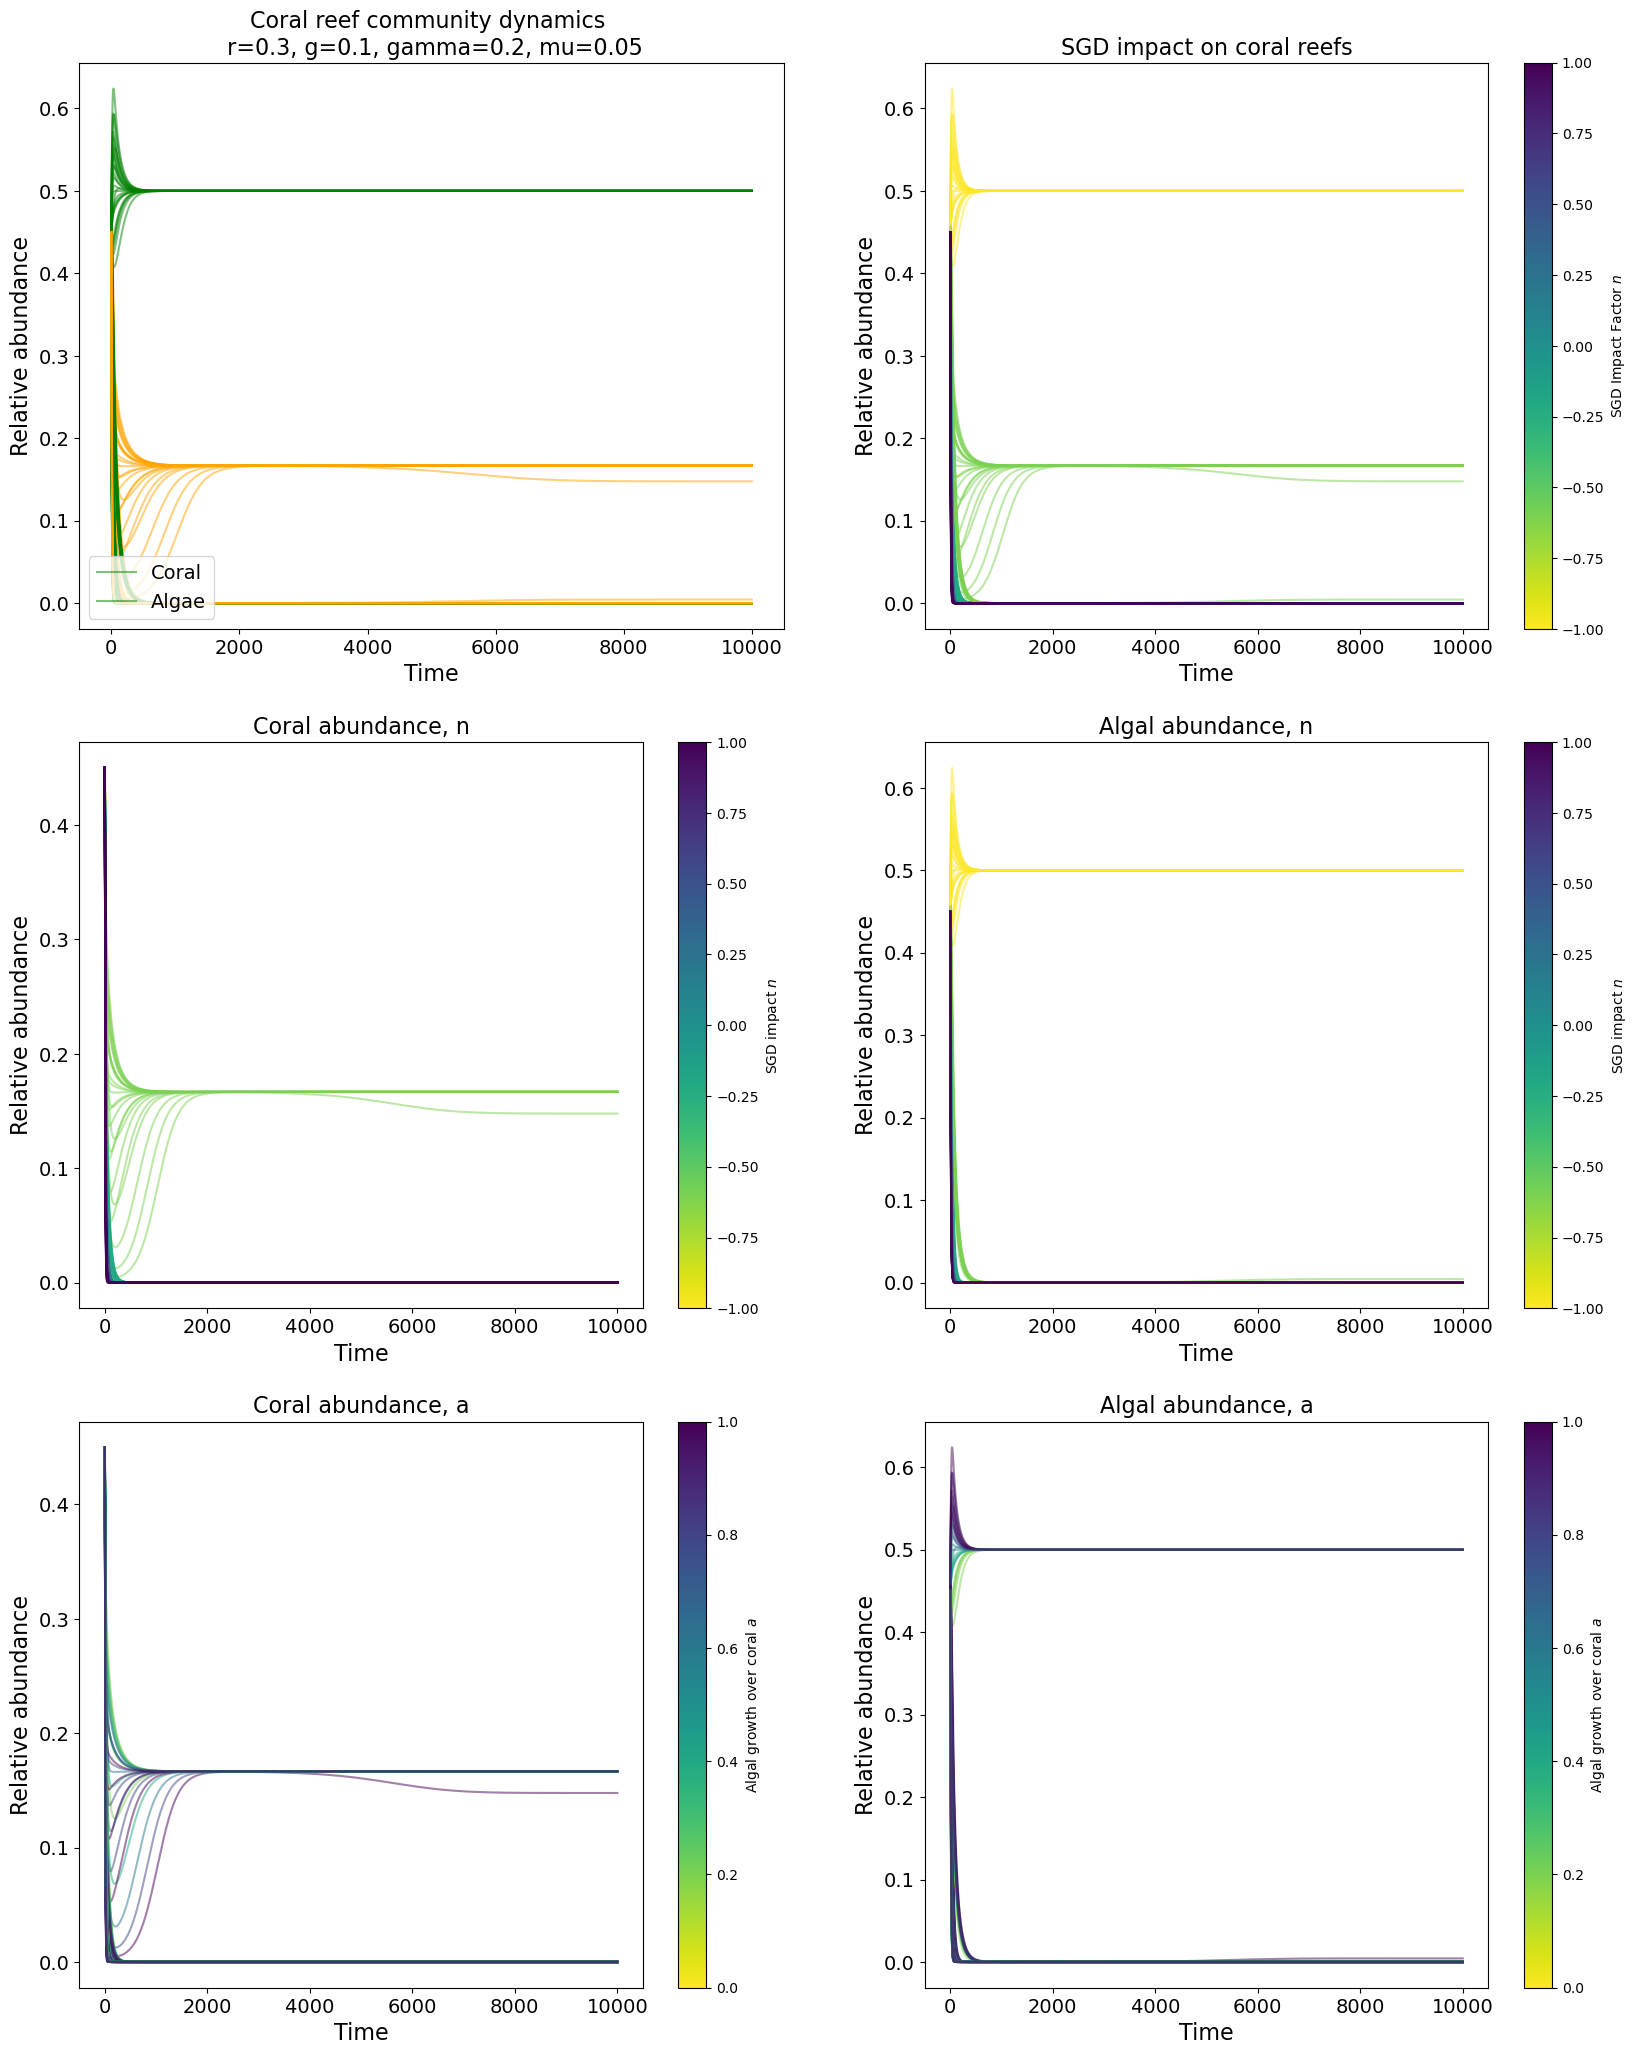

In [73]:

# initial SGD impact factors
nC = 0
nM = -1
a = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,25))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    
    for j in range(0,10):
        nM = nM + step
        a = 0
        
        for k in range(0,5):
            a = a + step
            
            if (C0 + M0 <= 1) : 
                C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
            if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                color = 'orange'
            else:
                color='green'
            if (C_array[-1] + M_array[-1] <= 1) : 
                ax1.plot(C_array, color = color, alpha = 0.5)
                ax1.plot(M_array, color = color, alpha = 0.5)
                ax2.plot(C_array, c=cmap(nC), alpha=0.5) # plot the coral time series in plot B
                ax2.plot(M_array, c=cmap(nM), alpha=0.5) # plot the macroalgae time series in plot B
                ax3.plot(C_array, c=cmap(nC), alpha=0.5)
                ax4.plot(M_array, c=cmap(nM), alpha=0.5)
                ax5.plot(C_array, c=cmap(a), alpha=0.5)
                ax6.plot(M_array, c=cmap(a), alpha=0.5)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n r='+str(r)+', g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);
plt.savefig("Output/H2_Mumby_iter_n_a.png", dpi=300);

## Iterate nC, nM, a, and r

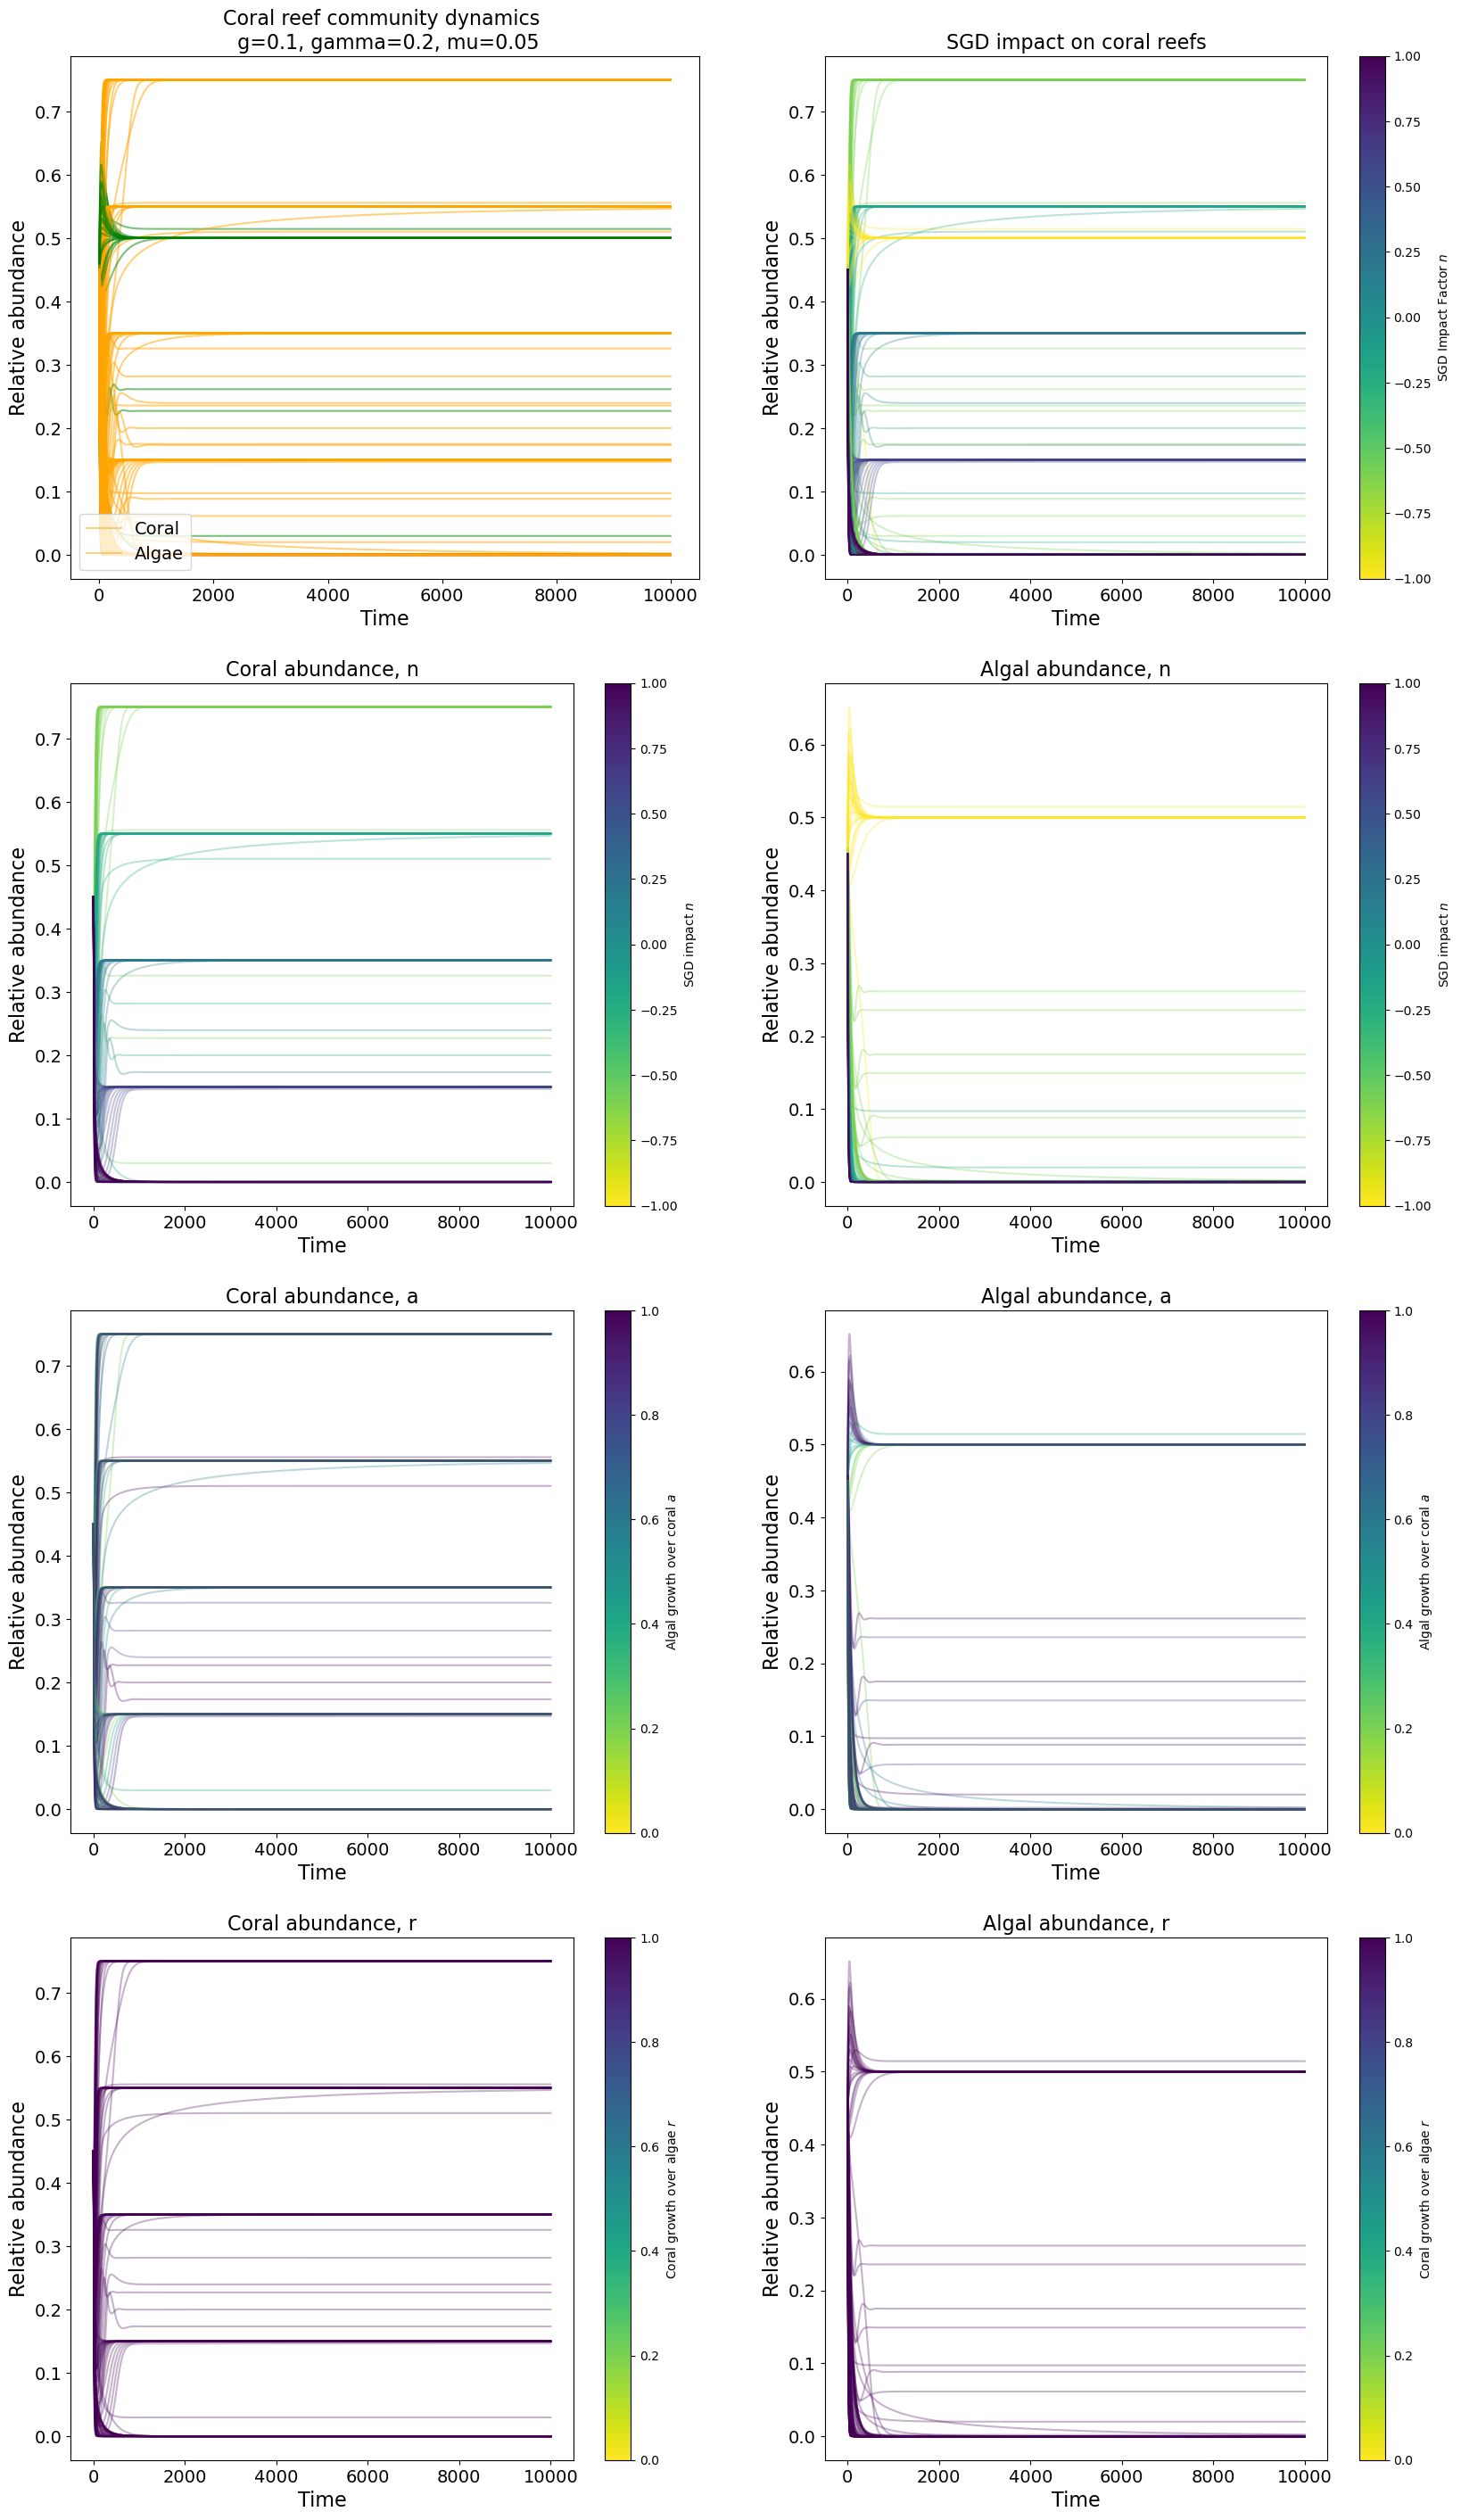

In [74]:

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,35))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            
            for m in range(0,5):
                r = r + step
            
            if (C0 + M0 <= 1) : 
                C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
            if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                color = 'orange'
            else:
                color='green'
            if (C_array[-1] + M_array[-1] <= 1) : 
                ax1.plot(C_array, color = color, alpha = 0.5)
                ax1.plot(M_array, color = color, alpha = 0.5)
                ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
                ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
                ax3.plot(C_array, c=cmap(nC), alpha=0.3)
                ax4.plot(M_array, c=cmap(nM), alpha=0.3)
                ax5.plot(C_array, c=cmap(a), alpha=0.3)
                ax6.plot(M_array, c=cmap(a), alpha=0.3)
                ax7.plot(C_array, c=cmap(r), alpha=0.3)
                ax8.plot(M_array, c=cmap(r), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n g='+str(g)+', gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);
plt.savefig("Output/H2_Mumby_iter_n_a_r.png", dpi=300);

## Iterate nC, nM, a, r, and gamma

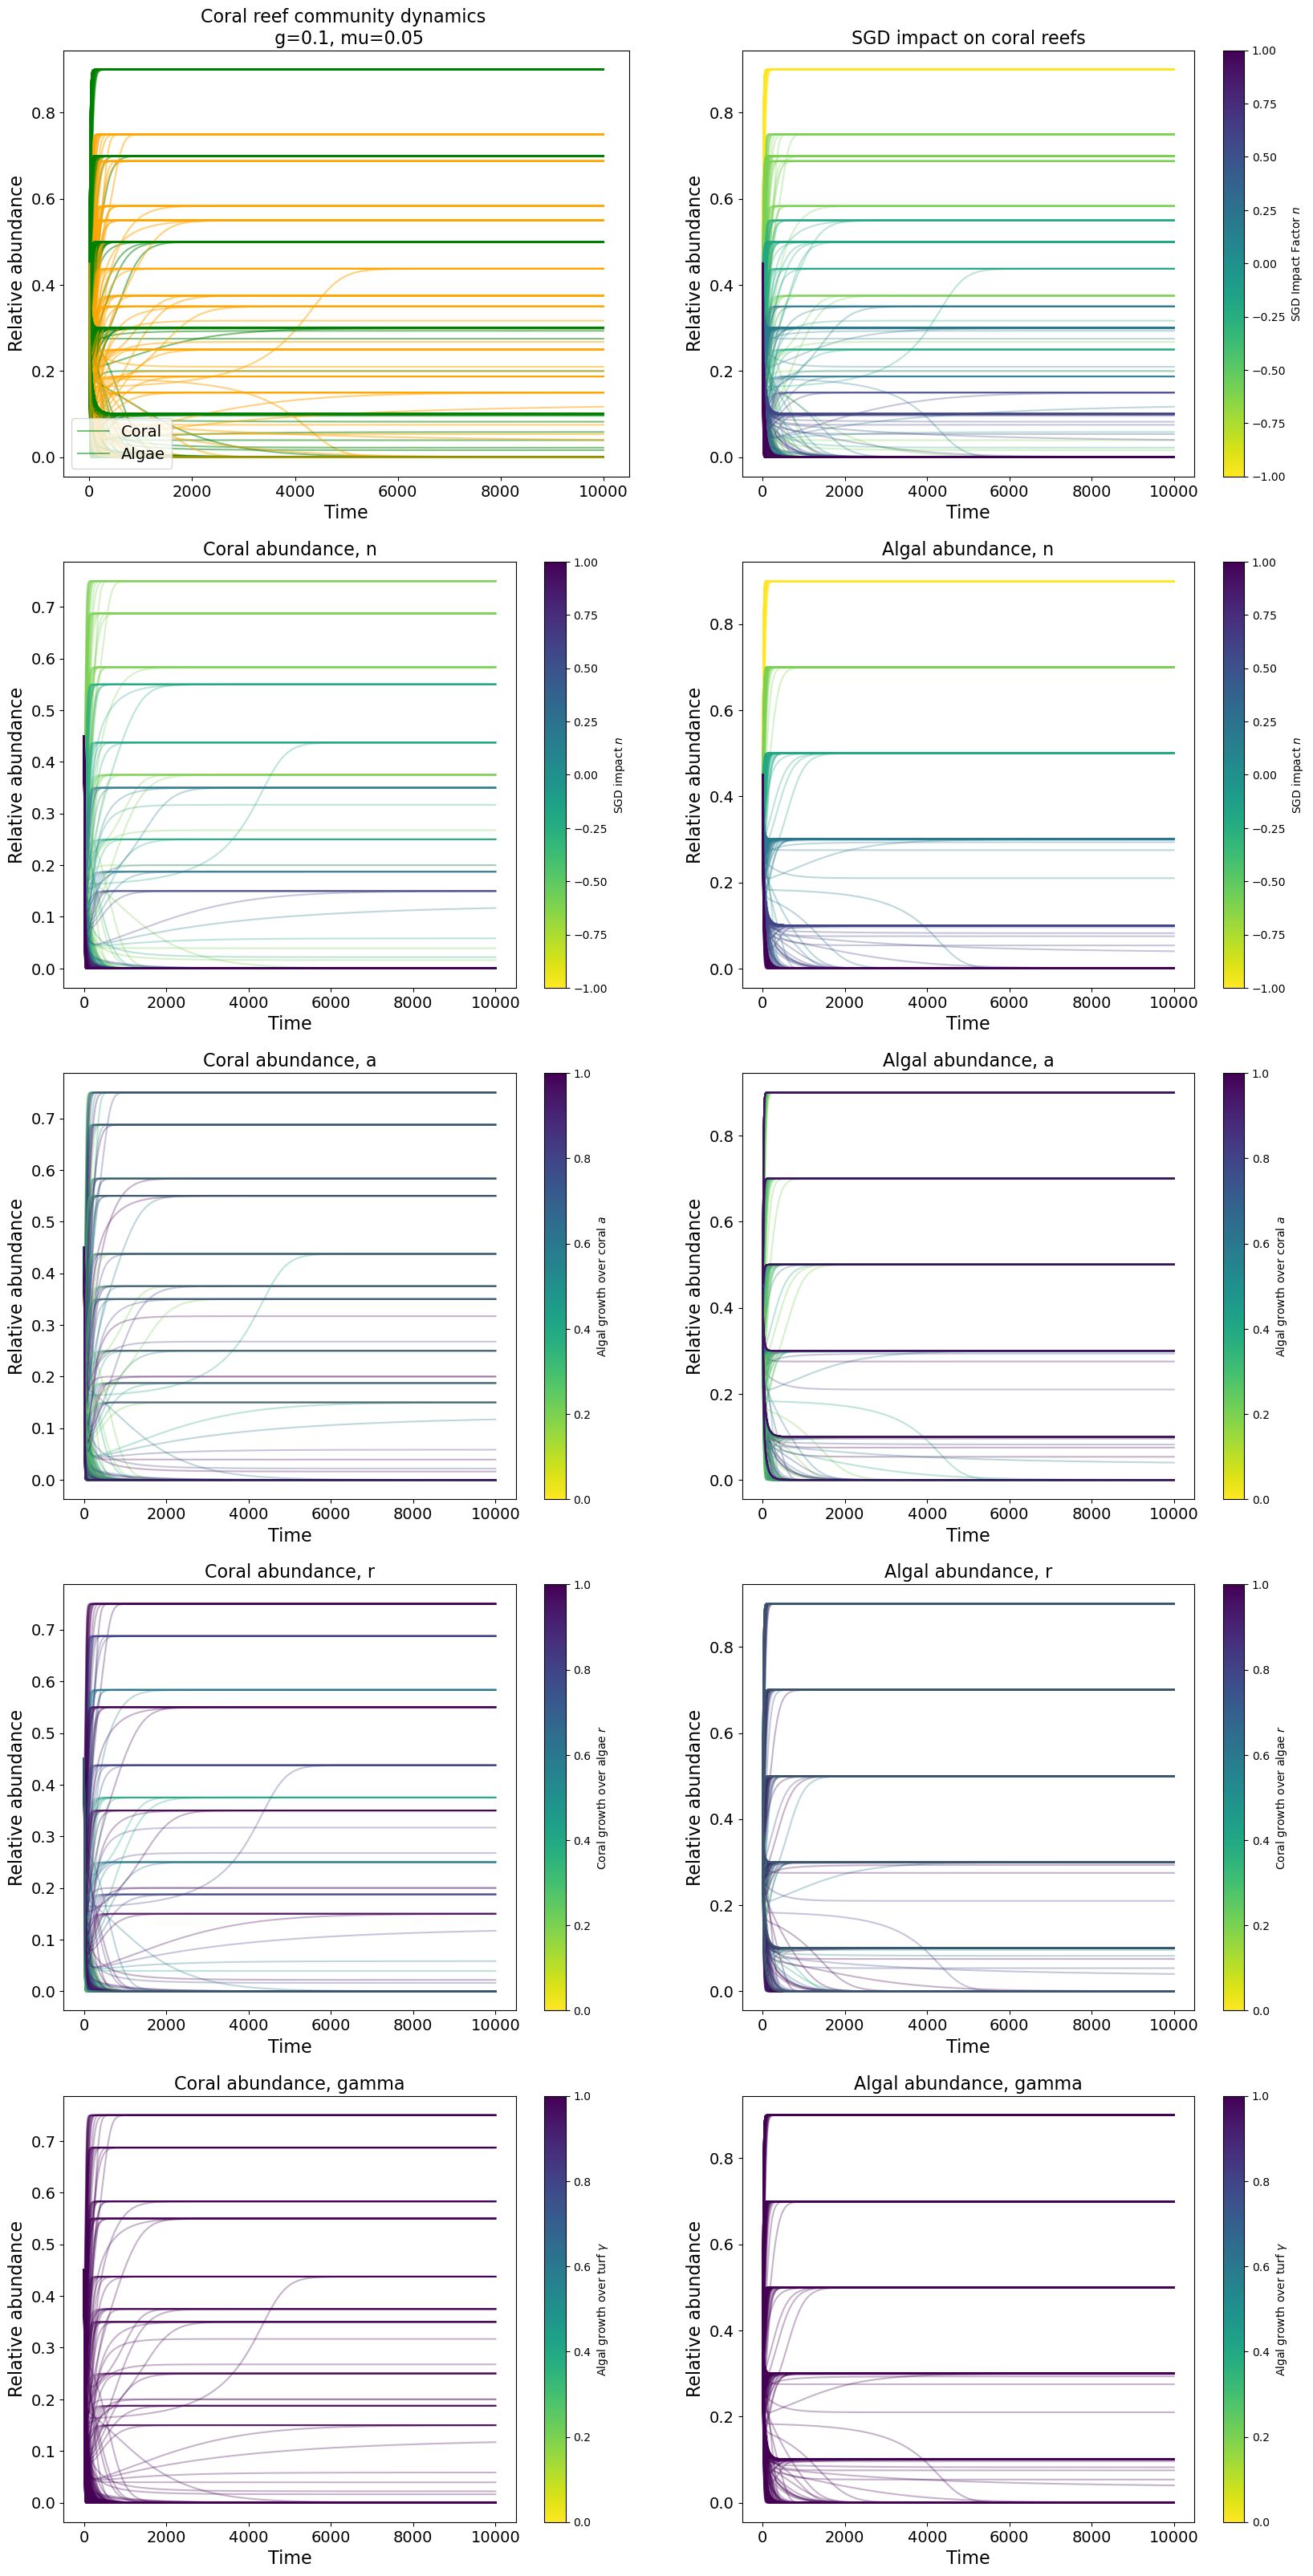

In [76]:

# time interval
# dt = 0.1 #step size
# NUMYEARS = 1000
# NUMSTEPS = int(NUMYEARS/dt)

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0
gamma = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20,40))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    gamma = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        gamma = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            gamma = 0
            
            for m in range(0,5):
                r = r + step
                gamma = 0
                
                for p in range(0,5):
                    gamma = gamma + step
            
                if (C0 + M0 <= 1) : 
                    C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                    color = 'orange'
                else:
                    color='green'
                if (C_array[-1] + M_array[-1] <= 1) : 
                    ax1.plot(C_array, color = color, alpha = 0.5)
                    ax1.plot(M_array, color = color, alpha = 0.5)
                    ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
                    ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
                    ax3.plot(C_array, c=cmap(nC), alpha=0.3)
                    ax4.plot(M_array, c=cmap(nM), alpha=0.3)
                    ax5.plot(C_array, c=cmap(a), alpha=0.3)
                    ax6.plot(M_array, c=cmap(a), alpha=0.3)
                    ax7.plot(C_array, c=cmap(r), alpha=0.3)
                    ax8.plot(M_array, c=cmap(r), alpha=0.3)
                    ax9.plot(C_array, c=cmap(gamma), alpha=0.3)
                    ax10.plot(M_array, c=cmap(gamma), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n g='+str(g)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax9, label = 'Algal growth over turf $\gamma$')
ax9.tick_params(axis='x', labelsize=14)
ax9.tick_params(axis='y', labelsize=14)
ax9.set_xlabel("Time", fontsize=16);
ax9.set_ylabel("Relative abundance", fontsize=16);
ax9.set_title('Coral abundance, gamma', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax10, label = 'Algal growth over turf $\gamma$')
ax10.tick_params(axis='x', labelsize=14)
ax10.tick_params(axis='y', labelsize=14)
ax10.set_xlabel("Time", fontsize=16);
ax10.set_ylabel("Relative abundance", fontsize=16)
ax10.set_title('Algal abundance, gamma', fontsize=16);
plt.savefig("Output/H2_Mumby_iter_n_a_r_gamma.png", dpi=300);

## Iterate nC, nM, a, r, and g

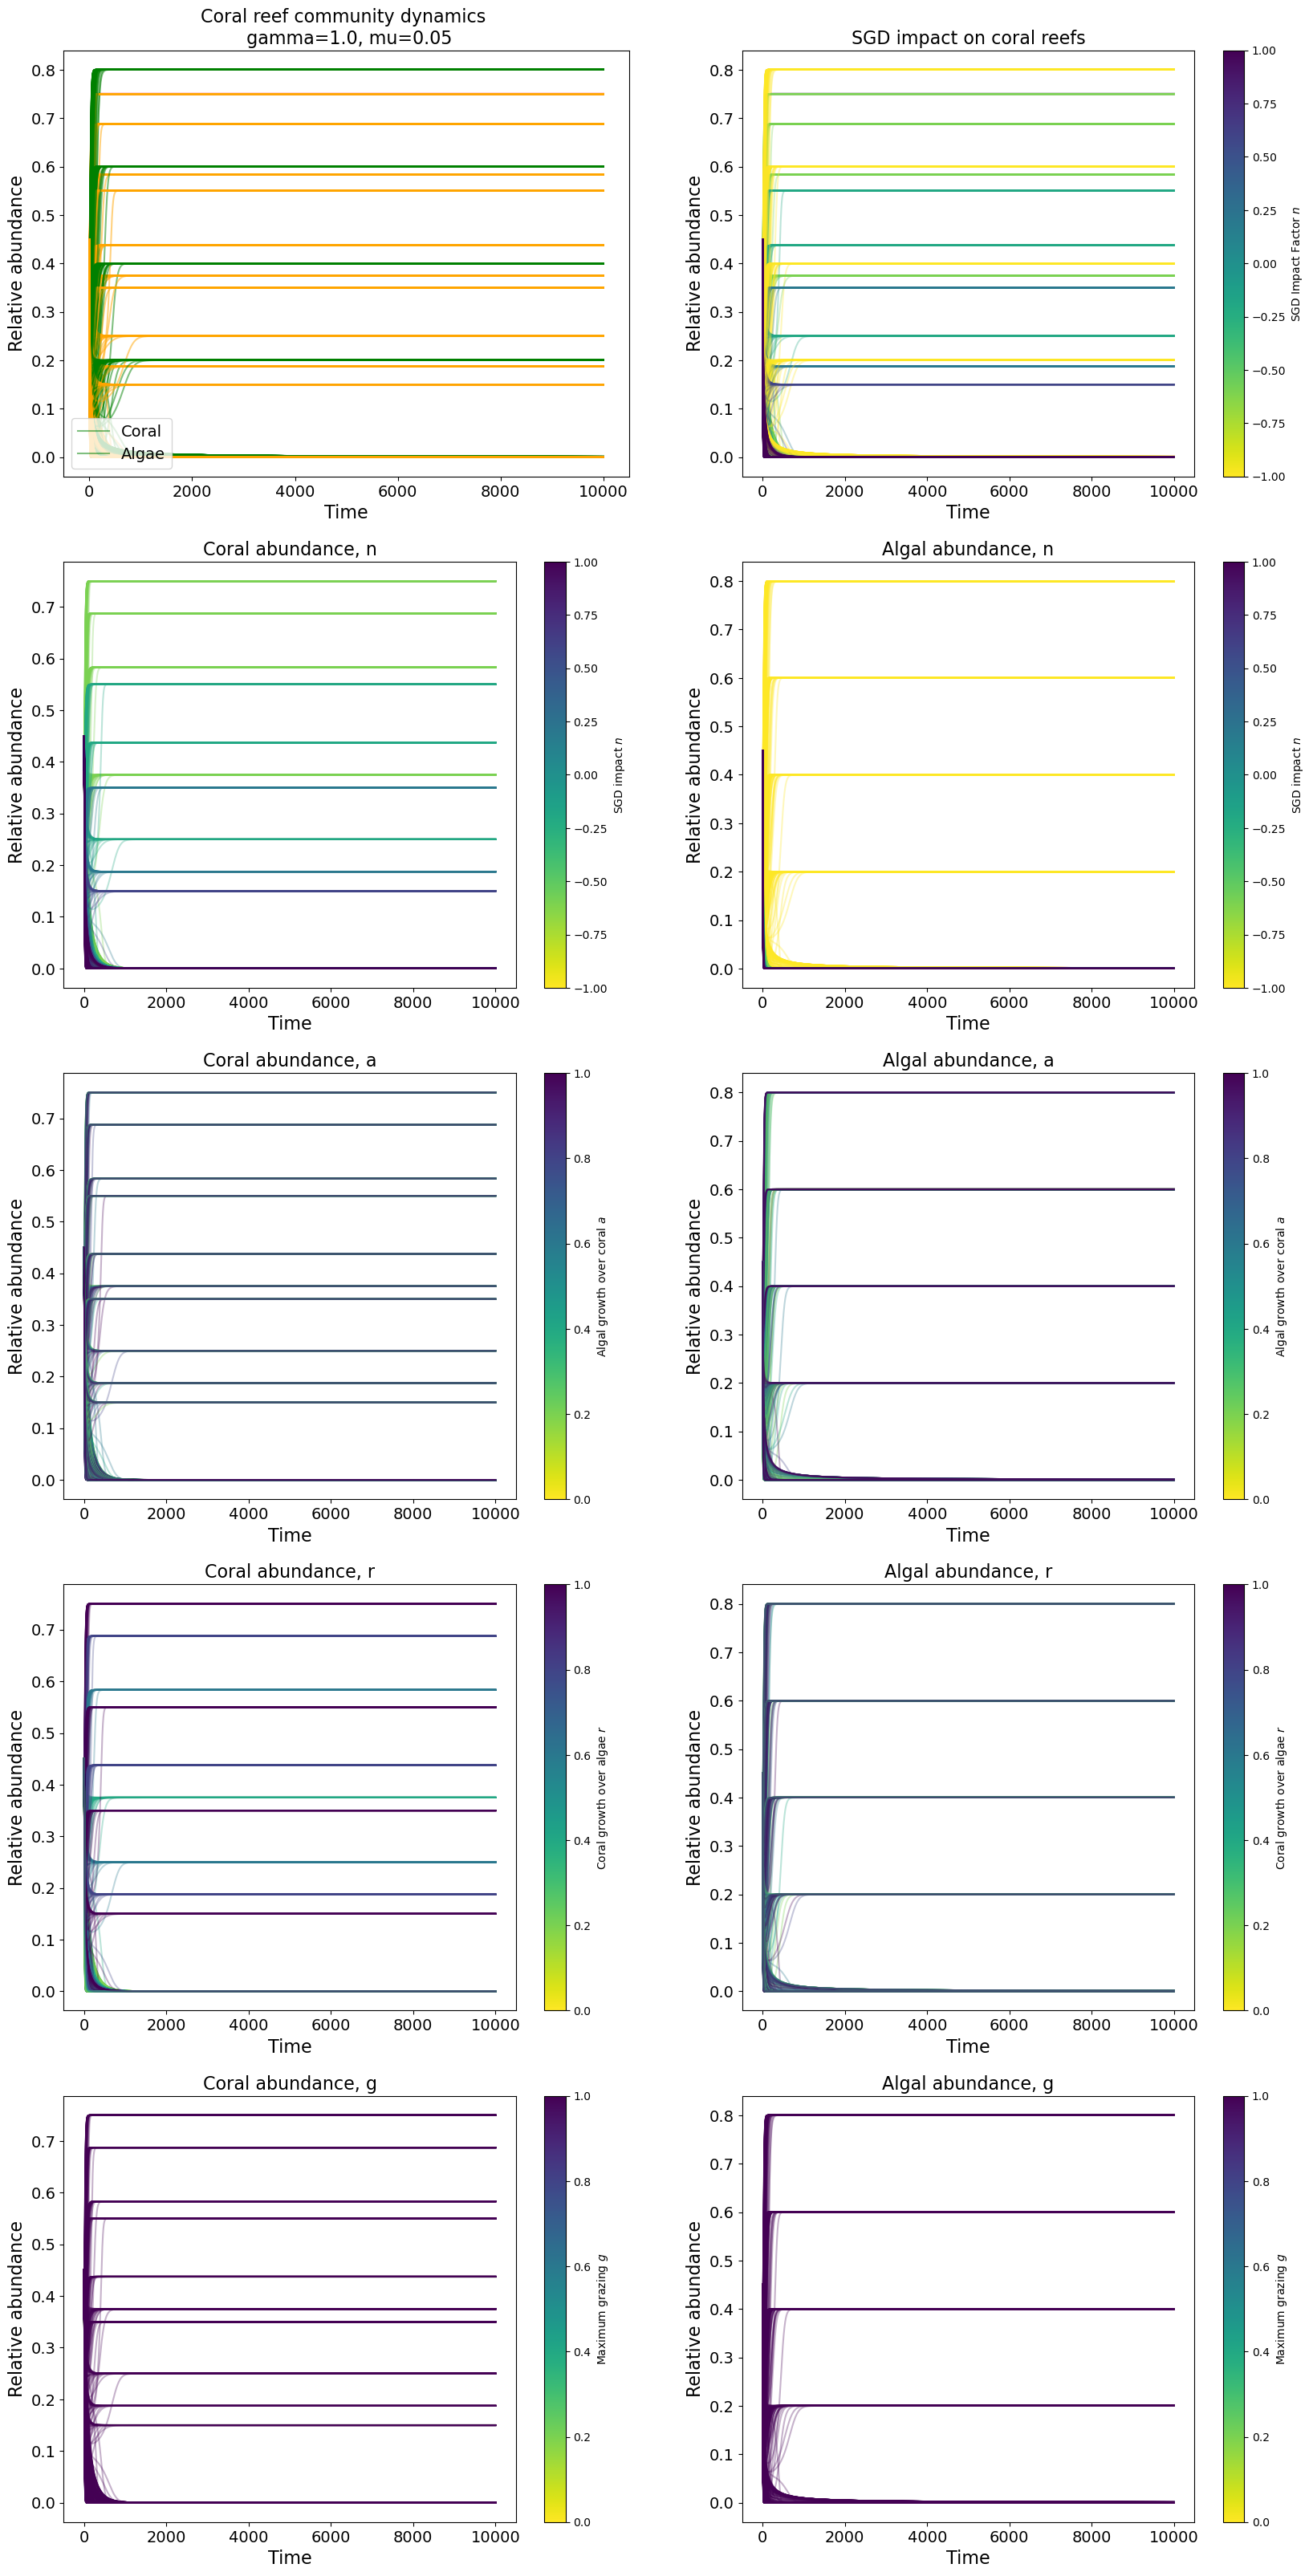

In [77]:

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0
g = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20,40))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    g = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        g = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            g = 0
            
            for m in range(0,5):
                r = r + step
                g = 0
                
                for p in range(0,5):
                    g = g + step
            
                if (C0 + M0 <= 1) : 
                    C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                    color = 'orange'
                else:
                    color='green'
                if (C_array[-1] + M_array[-1] <= 1) : 
                    ax1.plot(C_array, color = color, alpha = 0.5)
                    ax1.plot(M_array, color = color, alpha = 0.5)
                    ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
                    ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
                    ax3.plot(C_array, c=cmap(nC), alpha=0.3)
                    ax4.plot(M_array, c=cmap(nM), alpha=0.3)
                    ax5.plot(C_array, c=cmap(a), alpha=0.3)
                    ax6.plot(M_array, c=cmap(a), alpha=0.3)
                    ax7.plot(C_array, c=cmap(r), alpha=0.3)
                    ax8.plot(M_array, c=cmap(r), alpha=0.3)
                    ax9.plot(C_array, c=cmap(g), alpha=0.3)
                    ax10.plot(M_array, c=cmap(g), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n gamma='+str(gamma)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax9, label = 'Maximum grazing $g$')
ax9.tick_params(axis='x', labelsize=14)
ax9.tick_params(axis='y', labelsize=14)
ax9.set_xlabel("Time", fontsize=16);
ax9.set_ylabel("Relative abundance", fontsize=16);
ax9.set_title('Coral abundance, g', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax10, label = 'Maximum grazing $g$')
ax10.tick_params(axis='x', labelsize=14)
ax10.tick_params(axis='y', labelsize=14)
ax10.set_xlabel("Time", fontsize=16);
ax10.set_ylabel("Relative abundance", fontsize=16)
ax10.set_title('Algal abundance, g', fontsize=16);
plt.savefig("Output/H2_Mumby_iter_n_a_r_g.png", dpi=300);

In [ ]:
## Iterate nC, nM, a, r, gamma, and g

In [ ]:

# time interval
dt = 0.1 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)

# initial SGD impact factors
nC = 0
nM = -1
a = 0
r = 0
gamma = 0
g = 0

step = 0.2

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(20,50))
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

for i in range(0, 5):
# for i in np.arange(0,1, step):
    nC = nC + step
    nM = -1
    a = 0
    r = 0
    gamma = 0
    g = 0
    
    for j in range(0,10):
        nM = nM + step # first value used ends up being -0.8
        a = 0
        r = 0
        gamma = 0
        g = 0
        
        for k in range(0,5):
            a = a + step
            r = 0
            gamma = 0
            g = 0
            
            for m in range(0,5):
                r = r + step
                gamma = 0
                g = 0
                
                for p in range(0,5):
                    gamma = gamma + step
                    g = 0
                    
                    for q in range(0,5):
                        g = g + step
            
                    if (C0 + M0 <= 1) : 
                        C_array, M_array = run_model_RK2(C0,M0,parameters_dict)
                    if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
                        color = 'orange'
                    else:
                        color='green'
                    if (C_array[-1] + M_array[-1] <= 1) : 
                        ax1.plot(C_array, color = color, alpha = 0.5)
                        ax1.plot(M_array, color = color, alpha = 0.5)
                        ax2.plot(C_array, c=cmap(nC), alpha=0.3) # plot the coral time series in plot B
                        ax2.plot(M_array, c=cmap(nM), alpha=0.3) # plot the macroalgae time series in plot B
                        ax3.plot(C_array, c=cmap(nC), alpha=0.3)
                        ax4.plot(M_array, c=cmap(nM), alpha=0.3)
                        ax5.plot(C_array, c=cmap(a), alpha=0.3)
                        ax6.plot(M_array, c=cmap(a), alpha=0.3)
                        ax7.plot(C_array, c=cmap(r), alpha=0.3)
                        ax8.plot(M_array, c=cmap(r), alpha=0.3)
                        ax9.plot(C_array, c=cmap(gamma), alpha=0.3)
                        ax10.plot(M_array, c=cmap(gamma), alpha=0.3)
                        ax11.plot(C_array, c=cmap(g), alpha=0.3)
                        ax12.plot(M_array, c=cmap(g), alpha=0.3)

normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

ax1.legend(['Coral', 'Algae'], loc = "lower left", fontsize = 14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=16);
ax1.set_ylabel("Relative abundance", fontsize=16);
ax1.set_title('Coral reef community dynamics \n g='+str(g)+', mu='+str(mu), fontsize=16)
# plt.savefig("Output/H2_Mumby_Rand_iter_SGD_n.png", dpi=300);

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax2, label = 'SGD Impact Factor $n$')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('SGD impact on coral reefs', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax3, label = 'SGD impact $n$')
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_xlabel("Time", fontsize=16);
ax3.set_ylabel("Relative abundance", fontsize=16);
ax3.set_title('Coral abundance, n', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax4, label = 'SGD impact $n$')
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)
ax4.set_xlabel("Time", fontsize=16);
ax4.set_ylabel("Relative abundance", fontsize=16)
ax4.set_title('Algal abundance, n', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax5, label = 'Algal growth over coral $a$')
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.set_xlabel("Time", fontsize=16);
ax5.set_ylabel("Relative abundance", fontsize=16);
ax5.set_title('Coral abundance, a', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax6, label = 'Algal growth over coral $a$')
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)
ax6.set_xlabel("Time", fontsize=16);
ax6.set_ylabel("Relative abundance", fontsize=16)
ax6.set_title('Algal abundance, a', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax7, label = 'Coral growth over algae $r$')
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)
ax7.set_xlabel("Time", fontsize=16);
ax7.set_ylabel("Relative abundance", fontsize=16);
ax7.set_title('Coral abundance, r', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax8, label = 'Coral growth over algae $r$')
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)
ax8.set_xlabel("Time", fontsize=16);
ax8.set_ylabel("Relative abundance", fontsize=16)
ax8.set_title('Algal abundance, r', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax9, label = 'Algal growth over turf $\gamma$')
ax9.tick_params(axis='x', labelsize=14)
ax9.tick_params(axis='y', labelsize=14)
ax9.set_xlabel("Time", fontsize=16);
ax9.set_ylabel("Relative abundance", fontsize=16);
ax9.set_title('Coral abundance, gamma', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax10, label = 'Algal growth over turf $\gamma$')
ax10.tick_params(axis='x', labelsize=14)
ax10.tick_params(axis='y', labelsize=14)
ax10.set_xlabel("Time", fontsize=16);
ax10.set_ylabel("Relative abundance", fontsize=16)
ax10.set_title('Algal abundance, gamma', fontsize=16);

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax11, label = 'Maximum grazing rate $g$')
ax11.tick_params(axis='x', labelsize=14)
ax11.tick_params(axis='y', labelsize=14)
ax11.set_xlabel("Time", fontsize=16);
ax11.set_ylabel("Relative abundance", fontsize=16);
ax11.set_title('Coral abundance, g', fontsize=16)

fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax12, label = 'Maximum grazing rate $g$')
ax12.tick_params(axis='x', labelsize=14)
ax12.tick_params(axis='y', labelsize=14)
ax12.set_xlabel("Time", fontsize=16);
ax12.set_ylabel("Relative abundance", fontsize=16)
ax12.set_title('Algal abundance, g', fontsize=16);
plt.savefig("Output/H2_Mumby_iter_n_a_r_gamma_g.png", dpi=300);

In [ ]:

# # iterate through:
# r  #coral growth over turf
# a  #algal growth over coral
# mu  #coral mortality
# gamma  #algal growth over turf
# g  #maximum grazing rate

[Back to H1 Mumby](#hypothesis_1_mumby)  
[Back to H2 Mumby](#hypothesis_2_mumby)

<a name = "presentation_notes"></a>

## NOTES FOR PRESENTATION

2-species competition model: ($K_i = 1-sp_j$)

Lotka-Volterra Competition Model:
- Logistic model
$$\frac{\delta N}{\delta t} = rN(1-\frac{N}{K})$$

- Lotka-Volterra Competition Model:

$$\frac{\delta N_i}{\delta t} = N_i f_i(N_i, N_j)$$

$$\frac{\delta N_i}{\delta t} = r_i N_i (1 - a_{ii}N_i - a_{ij} N_j)$$

$$\frac{\delta N_i}{\delta t} = \frac{r_i N_i}{K_i} (K_i - N_i - \alpha_{ij} N_j)$$

- Lotka-Volterra Competition Models with SGD impact factor as a) growth impact or b) mortality factor

(a) $$\frac{\delta N_i}{\delta t} = \frac{r_i N_i}{K_i} (K_i - N_i - \alpha_{ij} N_j - K_i n_i N_i)$$

(b)  $$\frac{\delta N_i}{\delta t} = \frac{r_i N_i}{K_i} (K_i - N_i - \alpha_{ij} N_j) - n_i N_i$$

Variables:  
- $N$: Population size
- $r$: Intrinsic growth rate
- $K$: Carrying capacity, $K_i = 1 - N_j$ (Density-dependent proportional benthic cover, 0-1)
- $\alpha_{ij}$: Impact factor of species $j$ on species $i$
- $n$: Species-dependent impact factor of SGD

#### My Models:

$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M)$$ 
(1)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C)$$

2-species competition model including an environmental factor (n) impacting both species differently:

(where $n_i > 0$ has a negative impact on sp_i, and $n_i < 0$ has a positive impact on sp_i,
and $K_i = 1-sp_j-sp_k$)

Hypothesis 1: Growth impact  

$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M - K_C n_C C)$$ 
(2a)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C - K_M n_M M)$$


Hypothesis 2: Mortality factor  
$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M) - n_C C$$ 
(2b)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C) - n_M M$$


3-species competition model including an environmental factor (n) impacting all species differently (although I could make the generalization that turf and MA may be impacted similarly...): 

$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M - K_C n_C C)$$ 
(3)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C - \alpha_{M,T} T - K_M n_M M)$$

$$\frac{\delta T}{\delta t} = \frac{r_T T}{K_T}(K_T - T - \alpha_{T,M} M - K_T n_T T)$$
$$r_C < r_M < r_T$$

